In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
#记录一下Id列并删除它
test_labels = df_test['Id']

df_test.drop(columns=['Id'], inplace=True)
df_train.drop(columns=['Id'],inplace=True)

df_test['SalePrice'] = None

df_all = pd.concat([df_train, df_test], ignore_index=True)
print(df_all.shape)

(2919, 80)


# 一、探索重要变量

<Axes: xlabel='SalePrice', ylabel='Density'>

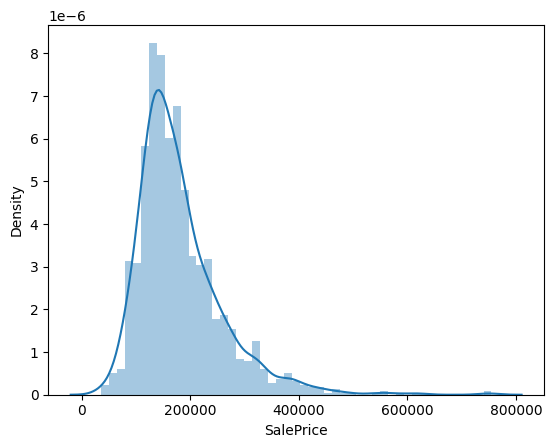

In [5]:
sns.distplot(df_train['SalePrice'])

In [6]:
#变量值类型是数值的个数
df_train.select_dtypes(include=['number']).shape[1]

37

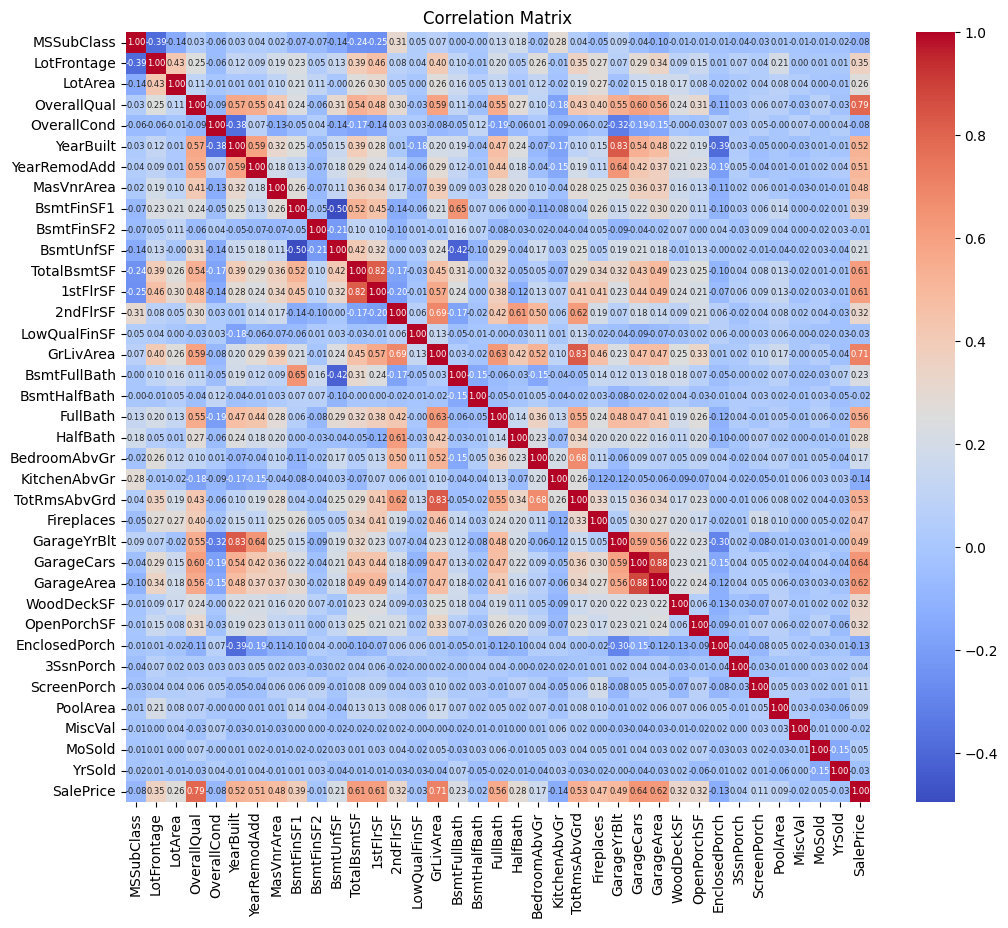

In [7]:
df_numeric=df_train.select_dtypes(include=['number'])
corr_matrix=df_numeric.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt='.2f',annot_kws={'size':6},cbar=True,
            xticklabels=corr_matrix.columns,
           yticklabels=corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

与SalePrice高度相关的变量有OverAllQual和GrLivArea

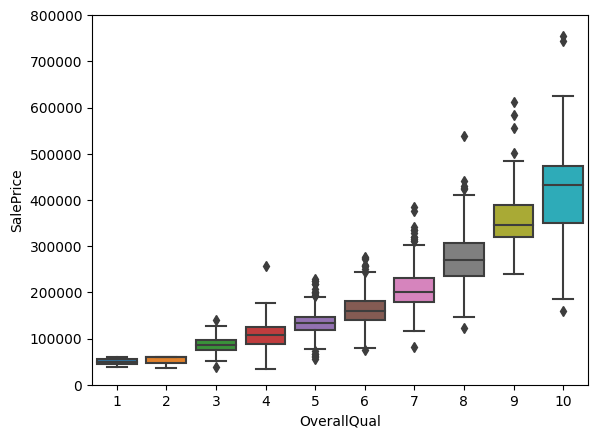

In [8]:
sns.boxplot(x='OverallQual',y='SalePrice',data=df_train)
plt.ylim(0, 800000)
plt.show()

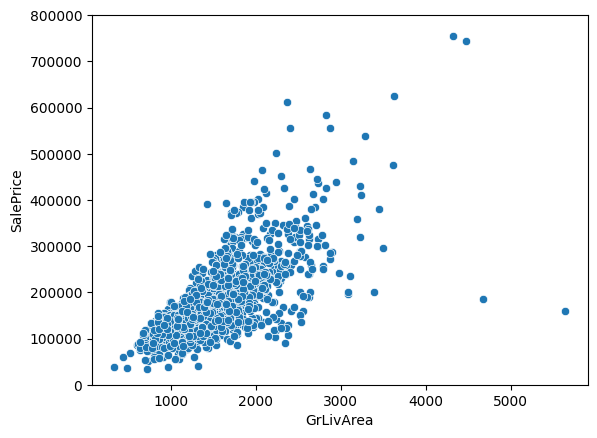

In [9]:
sns.scatterplot(x='GrLivArea',y='SalePrice',data=df_train)
plt.ylim(0, 800000)
plt.show()

从散点图上看出似乎存在两个面积很大但价格很低的异常值

# 二、数据预处理

## 1.缺失值处理

In [10]:
miss_tot = df_train.isnull().sum().sort_values(ascending=False)
miss_precent = (miss_tot / len(df_train)).sort_values(ascending=False)


missing_data = pd.concat([miss_tot, miss_precent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# (missing_data['Total']>0).sum()
# df_train.isnull().sum().sum()

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


### 逐个变量处理缺失值1 PoolQC
PoolQC包含了 Ex Good Average Fair NoPool

In [11]:
df_train['PoolQC'].unique()
#该列包含了五种值

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [12]:
#泳池数量为0的填充为None
df_train['PoolQC']=df_train['PoolQC'].fillna('None')

In [13]:
#创建字典用于映射
qualities = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

#使用replace方法将列中的值转换为证书类型
df_train['PoolQC']=df_train['PoolQC'].replace(qualities).astype(int)

#统计不同泳池QA级别的数量
print(df_train['PoolQC'].value_counts())

PoolQC
0    1453
4       3
5       2
2       2
Name: count, dtype: int64


### 逐个变量处理缺失值2 MiscFeature

In [14]:
#其他特征未涵盖的特殊项 因此不用特别关注
df_train['MiscFeature'].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

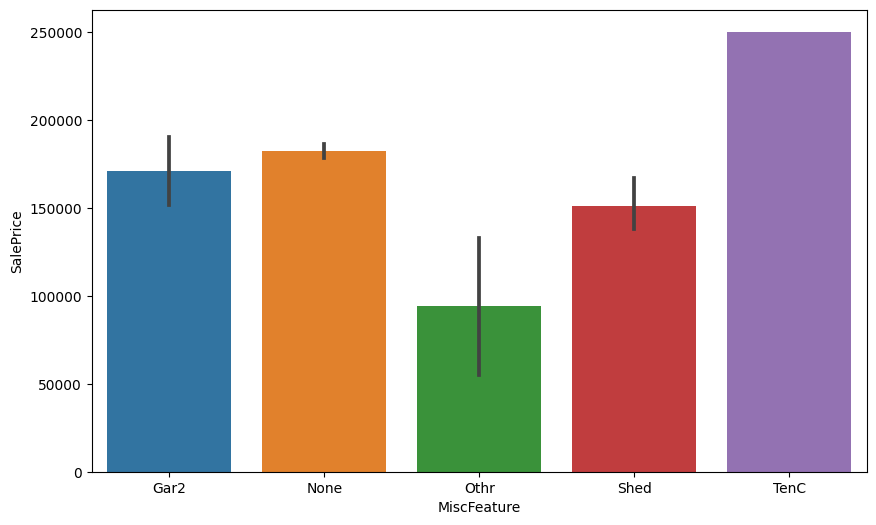

In [15]:
df_train['MiscFeature']=df_train['MiscFeature'].fillna('None')
df_train['MiscFeature'] = df_train['MiscFeature'].astype('category')

plt.figure(figsize=(10,6))
sns.barplot(x='MiscFeature',y='SalePrice',data=df_train)
#似乎有网球场TenC会更昂贵但是数据集中只有一个有网球场

### 逐个变量处理缺失值3 Alley

In [16]:
df_train['Alley'].unique()
#小巷类型

array([nan, 'Grvl', 'Pave'], dtype=object)

<Axes: xlabel='Alley', ylabel='SalePrice'>

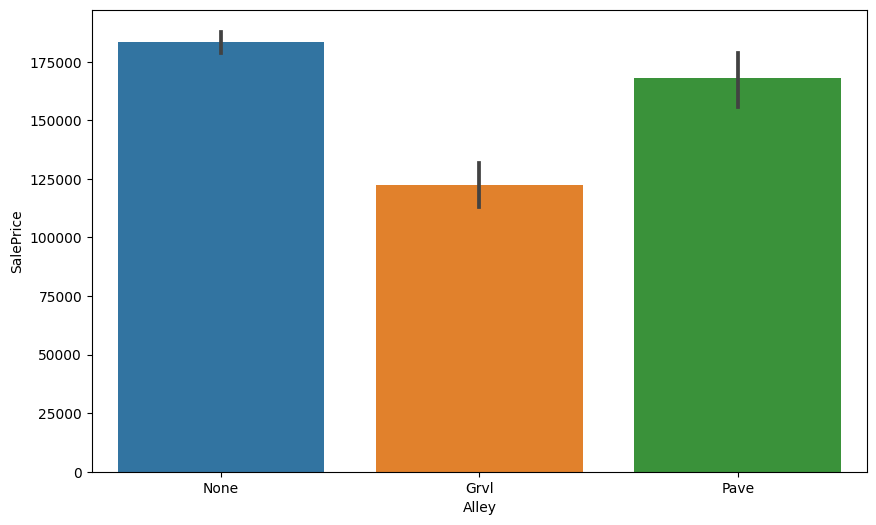

In [17]:
df_train['Alley']=df_train['Alley'].fillna('None')

plt.figure(figsize=(10,6))
sns.barplot(x='Alley',y='SalePrice',data=df_train)

### 逐个变量处理缺失值4 Fence

In [18]:
#栅栏质量
df_train['Fence'].value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

In [19]:
df_train['Fence']=df_train['Fence'].fillna('None')

#计算不同类别Fence的价格指标
summary = df_train.groupby('Fence')['SalePrice'].agg(
    median='median', 
    counts='size').reset_index()

summary

,Fence,median,counts
0,GdPrv,167500.0,59
1,GdWo,138750.0,54
2,MnPrv,137450.0,157
3,MnWw,130000.0,11
4,None,173000.0,1179


### 逐个变量处理缺失值5 FireplaceQu

In [20]:
df_train['FireplaceQu'].value_counts()

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

In [21]:
df_train['FireplaceQu']=df_train['FireplaceQu'].fillna('None')

qualities = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df_train['FireplaceQu']=df_train['FireplaceQu'].replace(qualities).astype(int)

print(df_train['PoolQC'].value_counts())

PoolQC
0    1453
4       3
5       2
2       2
Name: count, dtype: int64


### 逐个变量处理缺失值6 LotFrontage

In [22]:
print(type(df_train['Neighborhood']))

<class 'pandas.core.series.Series'>


In [23]:
#遍历每一行 将LotFrontage的缺失值按照 每一个Neighborhood分组的LotFrontage值的中位数进行填充
for i in range(len(df_train)):
    if pd.isna(df_train.loc[i, 'LotFrontage']):
        neighborhood = df_train.loc[i, 'Neighborhood']
        median_value = np.median(df_train.loc[df_train['Neighborhood'] == neighborhood, 'LotFrontage'].dropna())
        df_train.loc[i,'LotFrontage'] = int(median_value)

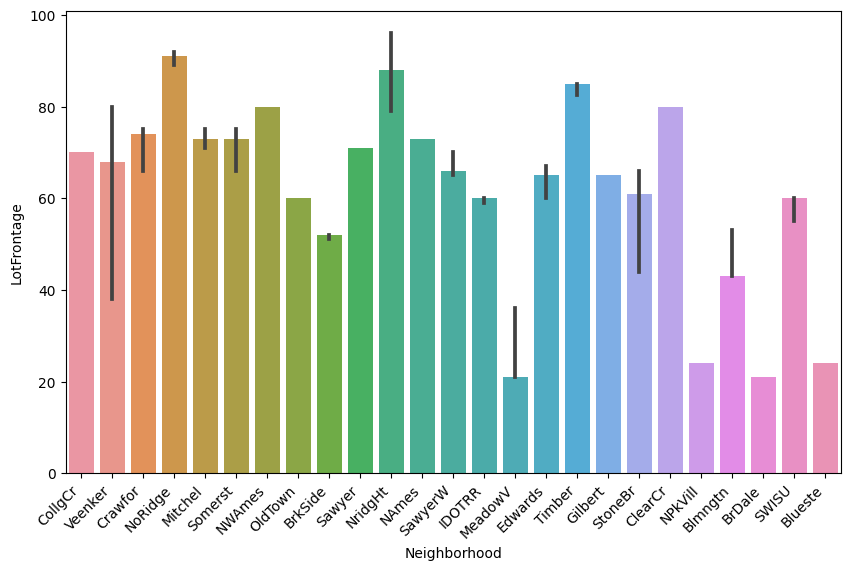

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Neighborhood',
    y='LotFrontage',
    data=df_train,
    estimator=np.median  # 直接使用 numpy 的 median 函数
)
plt.xticks(rotation=45, ha='right')
plt.show()

### 逐个变量处理缺失值7 Garch

总共与车库相关的变量有 7 个。

其中有五个变量有81个缺失值 分别是Garch-YrBlt Cond Type Finish Qual

先将所有缺失的“GarageYrBlt 车库建造年份”值替换为“YearBuilt”（建造年份）中的值。

In [25]:
# 处理缺失值GarageYrBlt 用YearBuild替代
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
df_train['GarageYrBlt']

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
1455    1999.0
1456    1978.0
1457    1941.0
1458    1950.0
1459    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [26]:
# 处理缺失值GarageType 缺失值为无车库
df_train['GarageType'] = df_train['GarageType'].fillna('No Garage')

df_train['GarageType'] = pd.Categorical(df_train['GarageType'])

print(df_train['GarageType'].value_counts())

GarageType
Attchd       870
Detchd       387
BuiltIn       88
No Garage     81
Basment       19
CarPort        9
2Types         6
Name: count, dtype: int64


In [27]:
# 处理缺失值GarageFinish
df_train['GarageFinish'] = df_train['GarageFinish'].fillna('None')

Finish = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}

df_train['GarageFinish']=df_train['GarageFinish'].map(Finish)

print(df_train['GarageFinish'].value_counts())

GarageFinish
1    605
2    422
3    352
0     81
Name: count, dtype: int64


In [28]:
# 处理缺失值GarageQual
df_train['GarageQual'] = df_train['GarageQual'].fillna('None')

# 使用映射字典将 'GarageQual' 列中的值替换为整数
df_train['GarageQual'] = df_train['GarageQual'].map(qualities)

# 显示每个整数类别的频数
print(df_train['GarageQual'].value_counts())

GarageQual
3    1311
0      81
2      48
4      14
5       3
1       3
Name: count, dtype: int64


In [29]:
# 处理缺失值GarageCond
df_train['GarageCond'] = df_train['GarageCond'].fillna('None')

# 使用映射字典将 'GarageQual' 列中的值替换为整数
df_train['GarageCond'] = df_train['GarageCond'].map(qualities)

# 显示每个整数类别的频数
print(df_train['GarageCond'].value_counts())

GarageCond
3    1326
0      81
2      35
4       9
1       7
5       2
Name: count, dtype: int64


### 逐个变量处理缺失值8 Basement
共有十一个变量和Basement相关

BsmtFinType2和BsmtExposure有38个缺失值

BsmtQual，BsmtCond，BsmtFinType1有37个缺失值

In [30]:
missing_count = ((df_train['BsmtQual'].isna()) & 
                 (df_train['BsmtCond'].isna()) & 
                 (df_train['BsmtExposure'].isna()) & 
                 (df_train['BsmtFinType1'].isna()) & 
                 (df_train['BsmtFinType2'].isna())).sum()

print(missing_count)

# 这鞋缺失值是包含关系

37


In [31]:
# 找到那个单独的一行 Exposure和FinType2是缺失其他四列不缺失的行
filtered_rows = df_train[~df_train['BsmtFinType1'].isna() & 
                    (~df_train['BsmtCond'].isna() & 
                     ~df_train['BsmtQual'].isna() & 
                     df_train['BsmtExposure'].isna() | 
                     df_train['BsmtFinType2'].isna())]

# 选择特定的列
result = filtered_rows[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]

print(result)


# 这两个单独的行说明是由Basement的只是缺失了值 其他的缺失行则是无Basement

    BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
332       Gd       TA           No          GLQ          NaN
948       Gd       TA          NaN          Unf          Unf


In [32]:
#用众数来替换那两个缺失值
#mode是返回列中的众数 如果有频率相同的则返回Series[0]则是取该系列的第一个值
df_train.loc[332,'BsmtFinType2'] = df_train['BsmtFinType2'].mode()[0]

df_train.loc[948,'BsmtExposure'] = df_train['BsmtExposure'].mode()[0]


In [33]:
# 处理缺失值Qual
df_train['BsmtQual'] = df_train['BsmtQual'].fillna('None')

df_train['BsmtQual'] = df_train['BsmtQual'].map(qualities)

print(df_train['BsmtQual'].value_counts())

BsmtQual
3    649
4    618
5    121
0     37
2     35
Name: count, dtype: int64


In [34]:
# 处理缺失值Cond
df_train['BsmtCond'] = df_train['BsmtCond'].fillna('None')

df_train['BsmtCond'] = df_train['BsmtCond'].map(qualities)

print(df_train['BsmtCond'].value_counts())

BsmtCond
3    1311
4      65
2      45
0      37
1       2
Name: count, dtype: int64


In [35]:
# 处理缺失值Exposure
exposure = {'None':0, 'No':'1', 'Mn':2, 'Av':3, 'Gd':4}

df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna('None')

df_train['BsmtExposure'] = df_train['BsmtExposure'].map(exposure).astype(int)

print(df_train['BsmtExposure'].value_counts())

BsmtExposure
1    954
3    221
4    134
2    114
0     37
Name: count, dtype: int64


In [36]:
# 处理缺失值FinType1
FinType = {'None':0, 'Unf':'1', 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}

df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('None')

df_train['BsmtFinType1'] = df_train['BsmtFinType1'].map(FinType).astype(int)

print(df_train['BsmtFinType1'].value_counts())

BsmtFinType1
1    430
6    418
5    220
4    148
3    133
2     74
0     37
Name: count, dtype: int64


In [37]:
# 处理缺失值FinType2
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna('None')

df_train['BsmtFinType2'] = df_train['BsmtFinType2'].map(FinType).astype(int)

print(df_train['BsmtFinType2'].value_counts())

BsmtFinType2
1    1257
3      54
2      46
0      37
4      33
5      19
6      14
Name: count, dtype: int64


### 逐个变量处理缺失值9 Masonry veneer
存在两个缺失值 VnrType 872个和 VnrArea 8个首先查看两者是否包含关系

In [38]:
len(df_train[df_train['MasVnrType'].isna() & df_train['MasVnrArea'].isna()])

#是包含关系

8

In [39]:
#修复缺失值MasVnrType 并查看
df_train['MasVnrType'].fillna('None',inplace=True)

result = df_train[df_train['SalePrice'].notna()]\
    .groupby('MasVnrType')\
    .agg(median=('SalePrice','median'), counts=('SalePrice','size'))\
    .reset_index()

result = result.sort_values(by='median')

print(result)

  MasVnrType    median  counts
0     BrkCmn  139000.0      15
2       None  143125.0     872
1    BrkFace  181000.0     445
3      Stone  246839.0     128


In [40]:
mansonry = {'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2}

df_train['MasVnrType'] = df_train['MasVnrType'].map(mansonry)

print(df_train['MasVnrType'].value_counts())

MasVnrType
0    887
1    445
2    128
Name: count, dtype: int64


In [41]:
#修复缺失值MasVnrArea
df_train['MasVnrArea'].fillna(0,inplace=True)

### 逐个变量处理缺失值10 Electrical

In [42]:
#用众数填充
most_frequent = df_train['Electrical'].mode()[0]
df_train['Electrical'].fillna(most_frequent, inplace=True)

print(df_train['Electrical'].value_counts())

Electrical
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64


In [43]:
#至此 所有缺失项全部修复完成
df_train.isnull().sum().sum()

0

## 2.字符变量转换为数值

### 标签编码1 Foundation

In [44]:
# 将 'Foundation' 列转换为分类变量
df_train['Foundation'] = df_train['Foundation'].astype('category')

# 查看 'Foundation' 列中每个类别的频数
df_train['Foundation'].value_counts()

Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64

### 标签编码2 Heating和Airco

In [45]:
#Heating有两个变量 Heating（类型）和HeatingQC
#和Airco相关的变量是CentralAir（是否）
df_train['Heating'] = df_train['Heating'].astype('category')
heating_counts = df_train['Heating'].value_counts()
print(heating_counts)


Heating
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64


In [46]:
df_train['HeatingQC'] = df_train['HeatingQC'].map(qualities)
heatingqc_counts = df_train['HeatingQC'].value_counts()
print(heatingqc_counts)

HeatingQC
5    741
3    428
4    241
2     49
1      1
Name: count, dtype: int64


In [47]:
central_air_map = {'N':0, 'Y':1}
df_train['CentralAir'] = df_train['CentralAir'].map(central_air_map)
central_air_counts = df_train['CentralAir'].value_counts()
print(central_air_counts)

CentralAir
1    1365
0      95
Name: count, dtype: int64


### 标签编码3 Roof

In [48]:
#RoofStyle 和 RoofMatl（材料）

df_train['RoofStyle'] = df_train['RoofStyle'].astype('category')
df_train['RoofStyle'].value_counts()

RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: count, dtype: int64

In [49]:
df_train['RoofMatl'] = df_train['RoofMatl'].astype('category')
df_train['RoofMatl'].value_counts()

RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Membran       1
Metal         1
Roll          1
Name: count, dtype: int64

### 标签编码4 Land

In [50]:
# LandCountour（平整程度） 和 LandSlope

df_train['LandContour'] = df_train['LandContour'].astype('category')
df_train['LandContour'].value_counts()

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

In [51]:
land_slope = {'Sev':0, 'Mod':1, 'Gtl':2}

df_train['LandSlope'] = df_train['LandSlope'].map(land_slope)
df_train['LandSlope'].value_counts()

LandSlope
2    1382
1      65
0      13
Name: count, dtype: int64

### 标签编码5 Dwelling

<Axes: xlabel='BldgType', ylabel='SalePrice'>

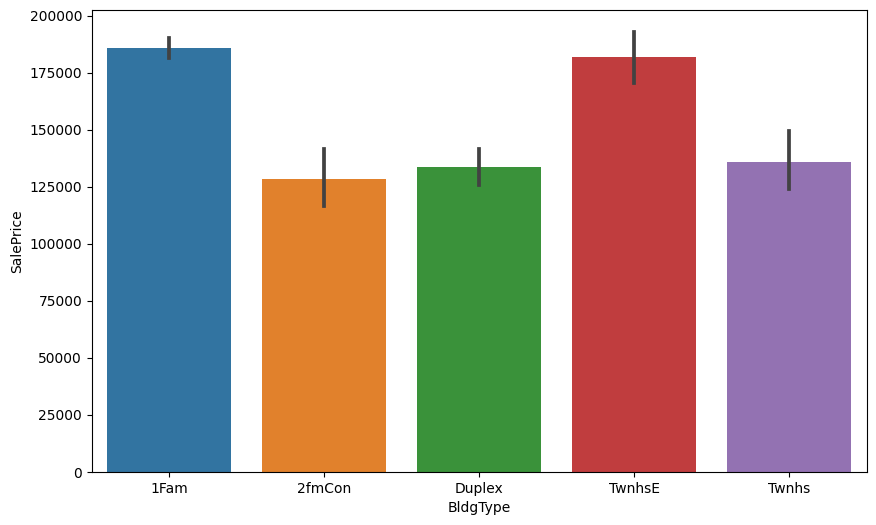

In [52]:
#BldgType（楼宇类型）和HouseStyle

#检查一下BldgType有没有明显的等级之分

plt.figure(figsize=(10,6))
sns.barplot(x='BldgType',y='SalePrice',data=df_train)
#结果显示并没有呈现出等级数据的特征

In [53]:
df_train['BldgType'] = df_train['BldgType'].astype('category')
df_train['BldgType'].value_counts()

BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64

In [54]:
df_train['HouseStyle'] = df_train['HouseStyle'].astype('category')
df_train['HouseStyle'].value_counts()

HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64

### 标签编码6 Neighborhood and Conditions

In [55]:
# Neighborhood（地理位置） Condition1 Condition2
df_train['Neighborhood'] = df_train['Neighborhood'].astype('category')
df_train['Neighborhood'].value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

In [56]:
df_train['Condition1'] = df_train['Condition1'].astype('category')
df_train['Condition1'].value_counts()

Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: count, dtype: int64

In [57]:
df_train['Condition2'] = df_train['Condition2'].astype('category')
df_train['Condition2'].value_counts()

Condition2
Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
PosA         1
RRAe         1
RRAn         1
Name: count, dtype: int64

### 标签编码7 Pavement & Driveway

In [58]:
# Street 和 PaveDrive
street = {'Grvl':0, 'Pave':1}

df_train['Street'] = df_train['Street'].map(street)
df_train['Street'].value_counts()

Street
1    1454
0       6
Name: count, dtype: int64

In [59]:
paved = {'N':0, 'P':1, 'Y':2}

df_train['PavedDrive'] = df_train['PavedDrive'].map(paved)
df_train['PavedDrive'].value_counts()

PavedDrive
2    1340
0      90
1      30
Name: count, dtype: int64

### 标签编码8 MSZoning

In [60]:
df_train['MSZoning'] = df_train['MSZoning'].astype('category')
df_train['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

### 标签编码9 Kitchen

In [61]:
df_train['KitchenQual'] = df_train['KitchenQual'].map(qualities)
df_train['KitchenQual'].value_counts()

KitchenQual
3    735
4    586
5    100
2     39
Name: count, dtype: int64

### 标签编码10 Utilitites

In [62]:
df_train['Utilities'].value_counts()
#可以看出只有一个房子没有公共设施，因此该变量在
#分析当中没有作用可以删除

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [63]:
df_train[df_train['Utilities'].isna() | (df_train['Utilities'] == 'NoSeWa')].iloc[:,:9]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities
944,20,RL,85.0,14375,1,None,IR1,Lvl,NoSeWa


In [64]:
df_train.drop(columns=['Utilities'], inplace=True)

### 标签编码11 Home functionality

In [65]:
# 家具功能
functional = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}

df_train['Functional'] = df_train['Functional'].map(functional)

df_train['Functional'].value_counts()

Functional
7    1360
5      34
6      31
4      15
3      14
2       5
1       1
Name: count, dtype: int64

### 标签编码12 Exterior

In [66]:
#Exterior1st
df_train['Exterior1st'] = df_train['Exterior1st'].astype('category')
df_train['Exterior1st'].value_counts()

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
CBlock       1
ImStucc      1
Name: count, dtype: int64

In [67]:
#Exterior2nd
df_train['Exterior2nd'] = df_train['Exterior2nd'].astype('category')
df_train['Exterior2nd'].value_counts()

Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: count, dtype: int64

In [68]:
# ExterQual
df_train['ExterQual'] = df_train['ExterQual'].map(qualities)
df_train['ExterQual'].value_counts()

ExterQual
3    906
4    488
5     52
2     14
Name: count, dtype: int64

In [69]:
#ExterCond
df_train['ExterCond'] = df_train['ExterCond'].map(qualities)
df_train['ExterCond'].value_counts()

ExterCond
3    1282
4     146
2      28
5       3
1       1
Name: count, dtype: int64

### 标签编码13 Sale Type and Condition

In [70]:
df_train['SaleType'] = df_train['SaleType'].astype('category')
df_train['SaleType'].value_counts()

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64

In [71]:
#SaleCondition
df_train['SaleCondition'] = df_train['SaleCondition'].astype('category')
df_train['SaleCondition'].value_counts()

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

## 3.转换数值型变量为分类变量

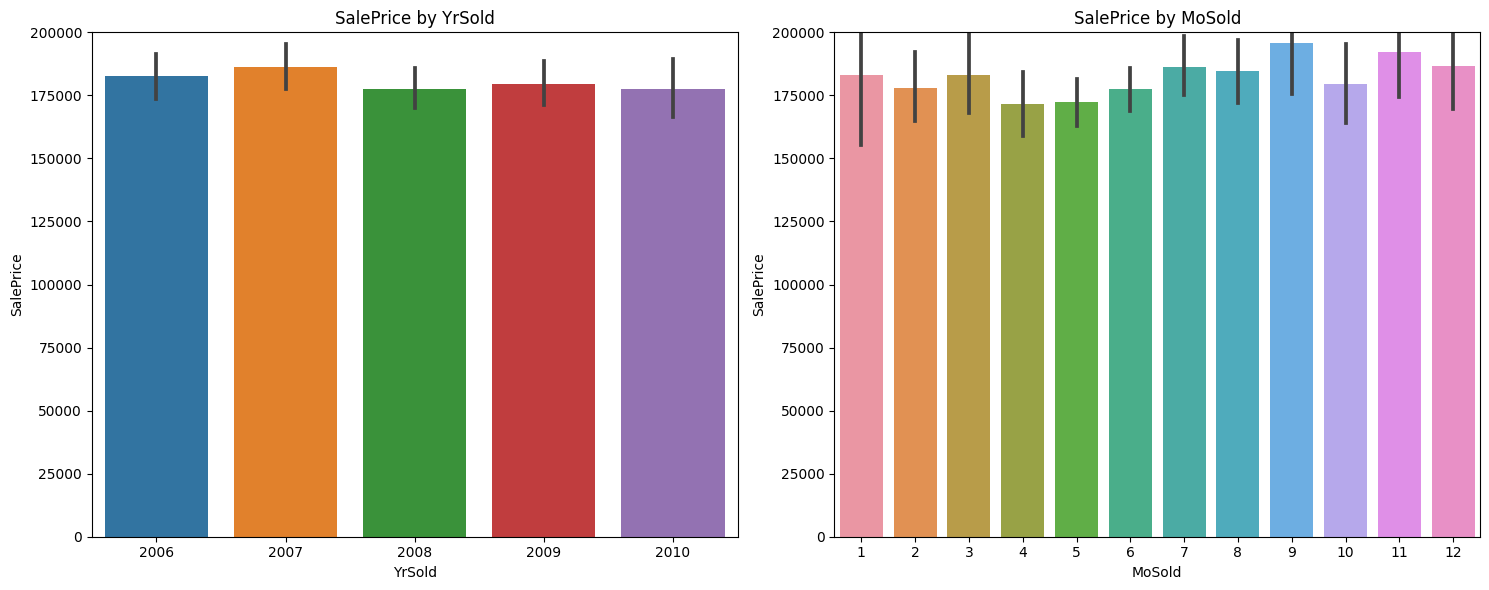

In [72]:
#YrSold看起来似乎是一个数值变量（新房比老房更贵）但是在这个数据集只考虑了五年期间的房价，
#并且期间还包括了经济危机。所以我将在建模前将 YrSold 转换为因子，但由于我需要 YrSold 的数值版本来创建一个 Age 变量，
#所以目前还没有这么做 只将MoSold进行转换。
df_train['MoSold'] = df_train['MoSold'].astype('category')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


sns.barplot(x='YrSold', y='SalePrice', data=df_train, ax=axes[0])
axes[0].set_ylim(0, 200000)
axes[0].set_title('SalePrice by YrSold')

# 第二个子图：MoSold 与 SalePrice 的关系
sns.barplot(x='MoSold', y='SalePrice', data=df_train, ax=axes[1])
axes[1].set_ylim(0, 200000)
axes[1].set_title('SalePrice by MoSold')

# 显示图形
plt.tight_layout()
plt.show()

#可以看出2007年底爆发的经济危机确实对于房价有着影响

In [73]:
df_train['MSSubClass']

0       60
1       20
2       60
3       70
4       60
        ..
1455    60
1456    20
1457    70
1458    20
1459    20
Name: MSSubClass, Length: 1460, dtype: int64

In [74]:
#MSSubClass指的是标识销售中涉及的住宅类型 确实是分类变量 数字代表的是类型编码
df_train['MSSubClass'] = df_train['MSSubClass'].astype('str')

# 为 'MSSubClass' 提供更具可读性的标签
ms_subclass = {
    '20': '1 story 1946+', 
    '30': '1 story 1945-', 
    '40': '1 story unf attic', 
    '45': '1,5 story unf', 
    '50': '1,5 story fin', 
    '60': '2 story 1946+', 
    '70': '2 story 1945-', 
    '75': '2,5 story all ages', 
    '80': 'split/multi level', 
    '85': 'split foyer', 
    '90': 'duplex all style/age', 
    '120': '1 story PUD 1946+', 
    '150': '1,5 story PUD all', 
    '160': '2 story PUD 1946+', 
    '180': 'PUD multilevel', 
    '190': '2 family conversion'
}

# 用 map() 将 'MSSubClass' 列的值替换为更具描述性的标签
df_train['MSSubClass'] = df_train['MSSubClass'].replace(ms_subclass)# 注意map是字符串匹配 所以没有转成category
df_train['MSSubClass'] = df_train['MSSubClass'].astype('category')

print(df_train['MSSubClass'].value_counts())

MSSubClass
1 story 1946+           536
2 story 1946+           299
1,5 story fin           144
1 story PUD 1946+        87
1 story 1945-            69
2 story PUD 1946+        63
2 story 1945-            60
split/multi level        58
duplex all style/age     52
2 family conversion      30
split foyer              20
2,5 story all ages       16
1,5 story unf            12
PUD multilevel           10
1 story unf attic         4
Name: count, dtype: int64


# 三、可视化重要特征

In [75]:
# 查看列数量
len(df_train.columns)
#df_train.columns
#df_train.shape

79

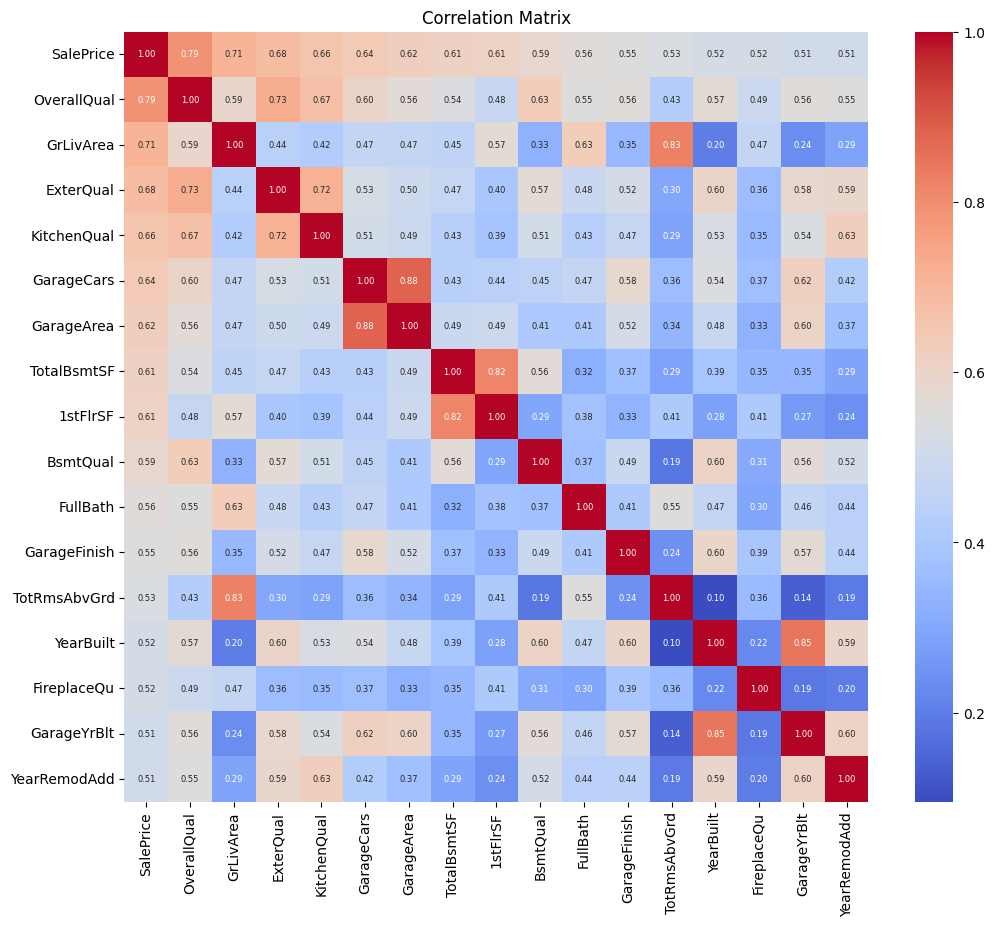

In [76]:
#可视化高相关度的变量 只能数值变量
df_numeric=df_train.select_dtypes(include=['number'])
corr_matrix=df_numeric.corr()

corr_sorted = corr_matrix['SalePrice'].sort_values(ascending = False)
corr_high = corr_sorted[corr_sorted.abs()>0.5].index
corr_num_high = corr_matrix.loc[corr_high, corr_high]

plt.figure(figsize=(12,10))
sns.heatmap(corr_num_high,annot=True,cmap='coolwarm',fmt='.2f',annot_kws={'size':6},cbar=True,
            xticklabels=corr_num_high.columns,
           yticklabels=corr_num_high.columns)
plt.title('Correlation Matrix')
plt.show()

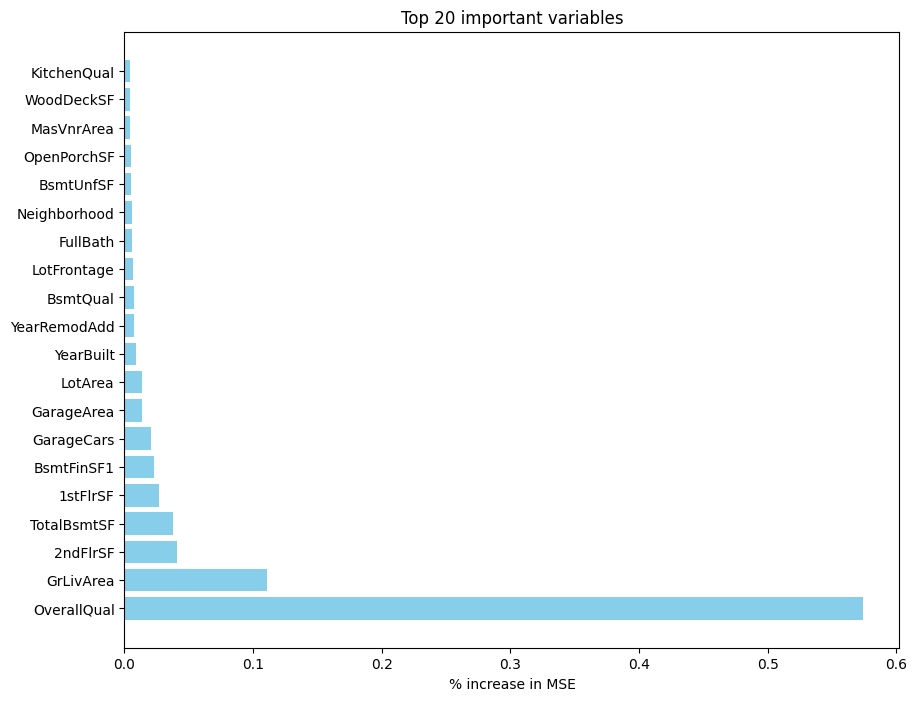

In [77]:
# 使用随机森林列出变量重要性排序
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

quick_rf = RandomForestRegressor(n_estimators=100, random_state=2018)

X = df_train.iloc[:1460, :-1]
y = df_train['SalePrice'].iloc[:1460]

#字符类型列进行Label Encoding
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object', 'category']).columns:
    X[column] = label_encoder.fit_transform(X[column])    


quick_rf.fit(X, y)

importance = quick_rf.feature_importances_

imp_df = pd.DataFrame({
    'Variables':X.columns,
    'MSE':importance
})

imp_df = imp_df.sort_values(by='MSE', ascending = False)

plt.figure(figsize=(10,8))
plt.barh(imp_df['Variables'].head(20), imp_df['MSE'].head(20), color='skyblue')
plt.xlabel('% increase in MSE')
plt.title('Top 20 important variables')
plt.show()

### 房屋面积变量

In [78]:
# #安装SimHei字体
# !apt-get update
# !apt-get install -y fonts-noto-cjk

Text(0.5, 0, 'Low Quality First & Second Floor')

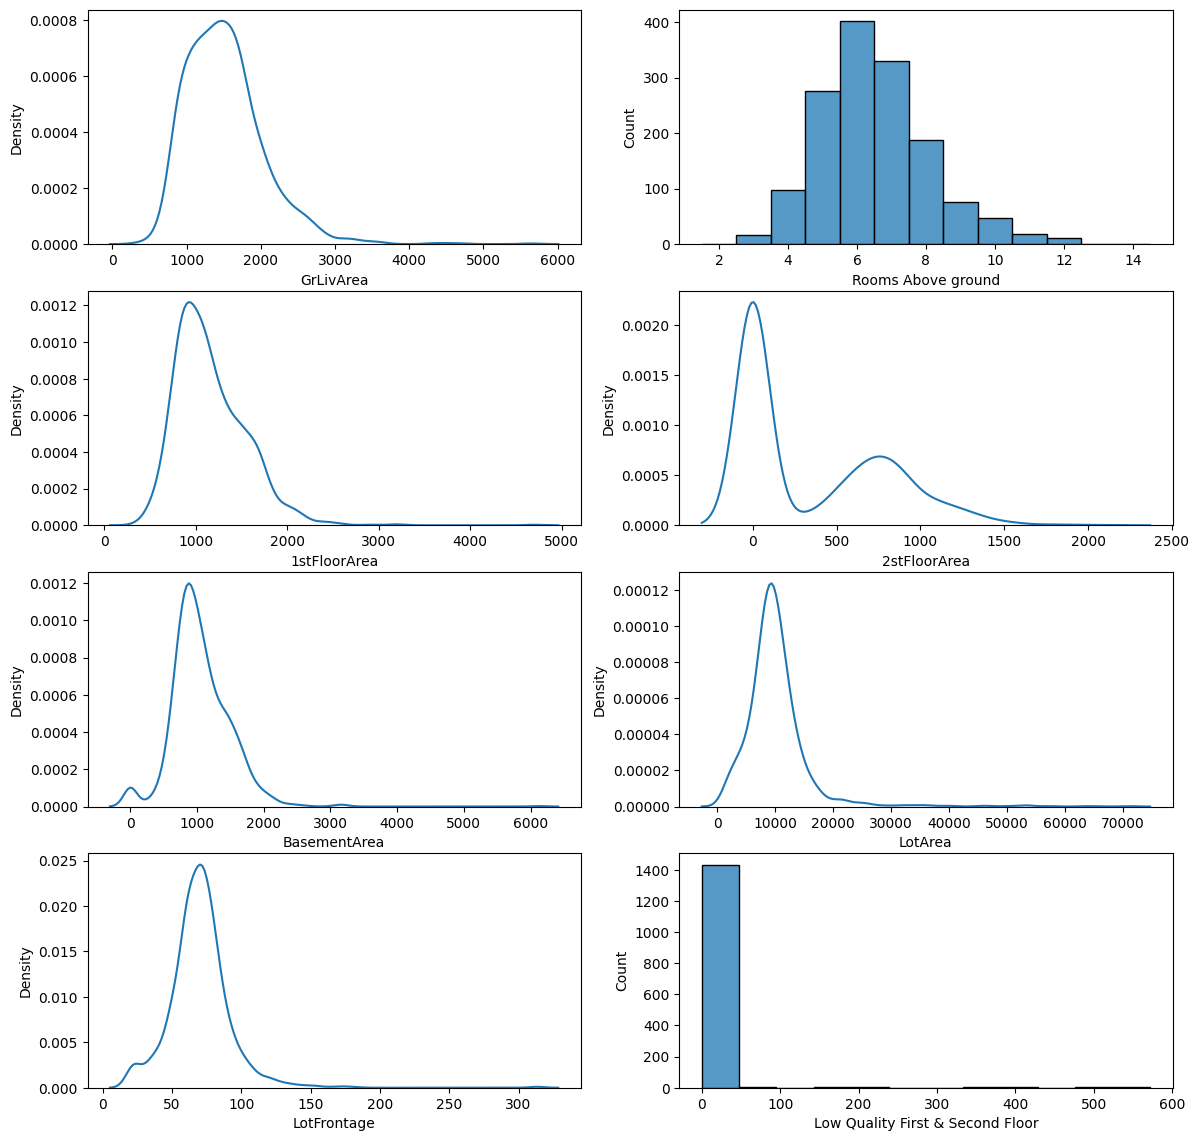

In [79]:
fig, axes = plt.subplots(4,2,figsize=(14,14))

sns.kdeplot(x='GrLivArea', ax=axes[0,0], data=df_train)
axes[0,0].set_label('GrLivArea')

sns.histplot(x='TotRmsAbvGrd', ax=axes[0,1], discrete=True, data=df_train)
axes[0,1].set_xlabel('Rooms Above ground')

sns.kdeplot(x='1stFlrSF', ax=axes[1, 0], data=df_train)
axes[1, 0].set_xlabel('1stFloorArea')

sns.kdeplot(x='2ndFlrSF', ax=axes[1, 1], data=df_train)
axes[1, 1].set_xlabel('2stFloorArea')

sns.kdeplot( x='TotalBsmtSF', ax=axes[2, 0],data=df_train)
axes[2, 0].set_xlabel('BasementArea')

sns.kdeplot(x='LotArea', ax=axes[2, 1], data=df_train[df_train['LotArea'] < 100000])
axes[2, 1].set_xlabel('LotArea')

sns.kdeplot( x='LotFrontage', ax=axes[3, 0], data=df_train)
axes[3, 0].set_xlabel('LotFrontage')

sns.histplot( x='LowQualFinSF', ax=axes[3, 1], data=df_train)
axes[3, 1].set_xlabel('Low Quality First & Second Floor')

### 街区变量

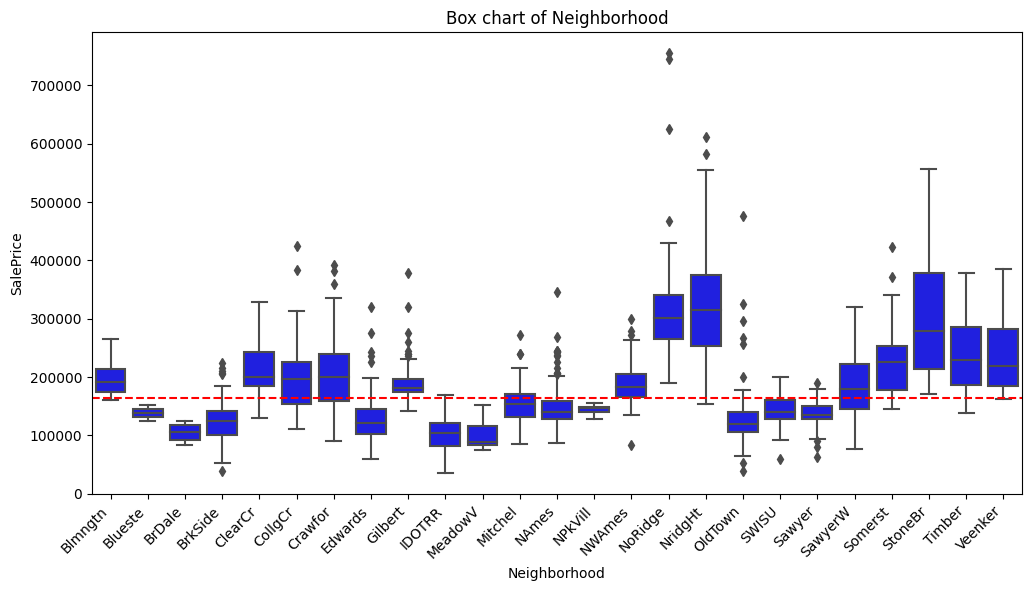

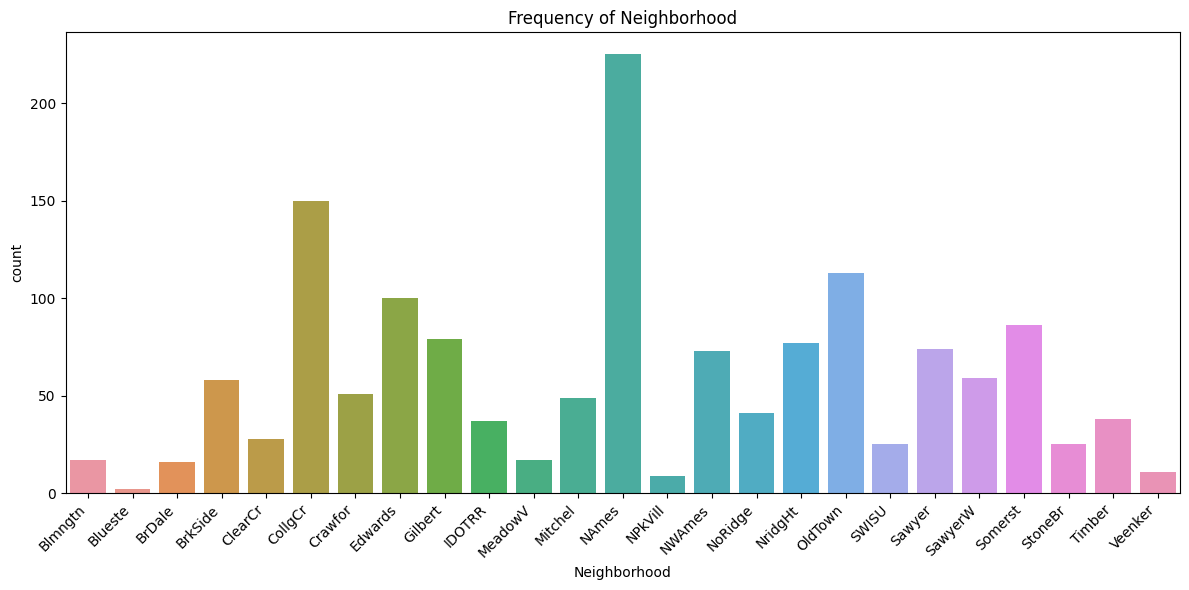

In [80]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train.dropna(subset=['SalePrice']), color='blue')

plt.xticks(rotation=45, ha='right')
plt.axhline(y=df_train['SalePrice'].median(), color='red', linestyle='--')
plt.title('Box chart of Neighborhood')

plt.figure(figsize=(12,6))
sns.countplot(x='Neighborhood', data=df_train)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Neighborhood')

plt.tight_layout()
plt.show()

### 质量变量

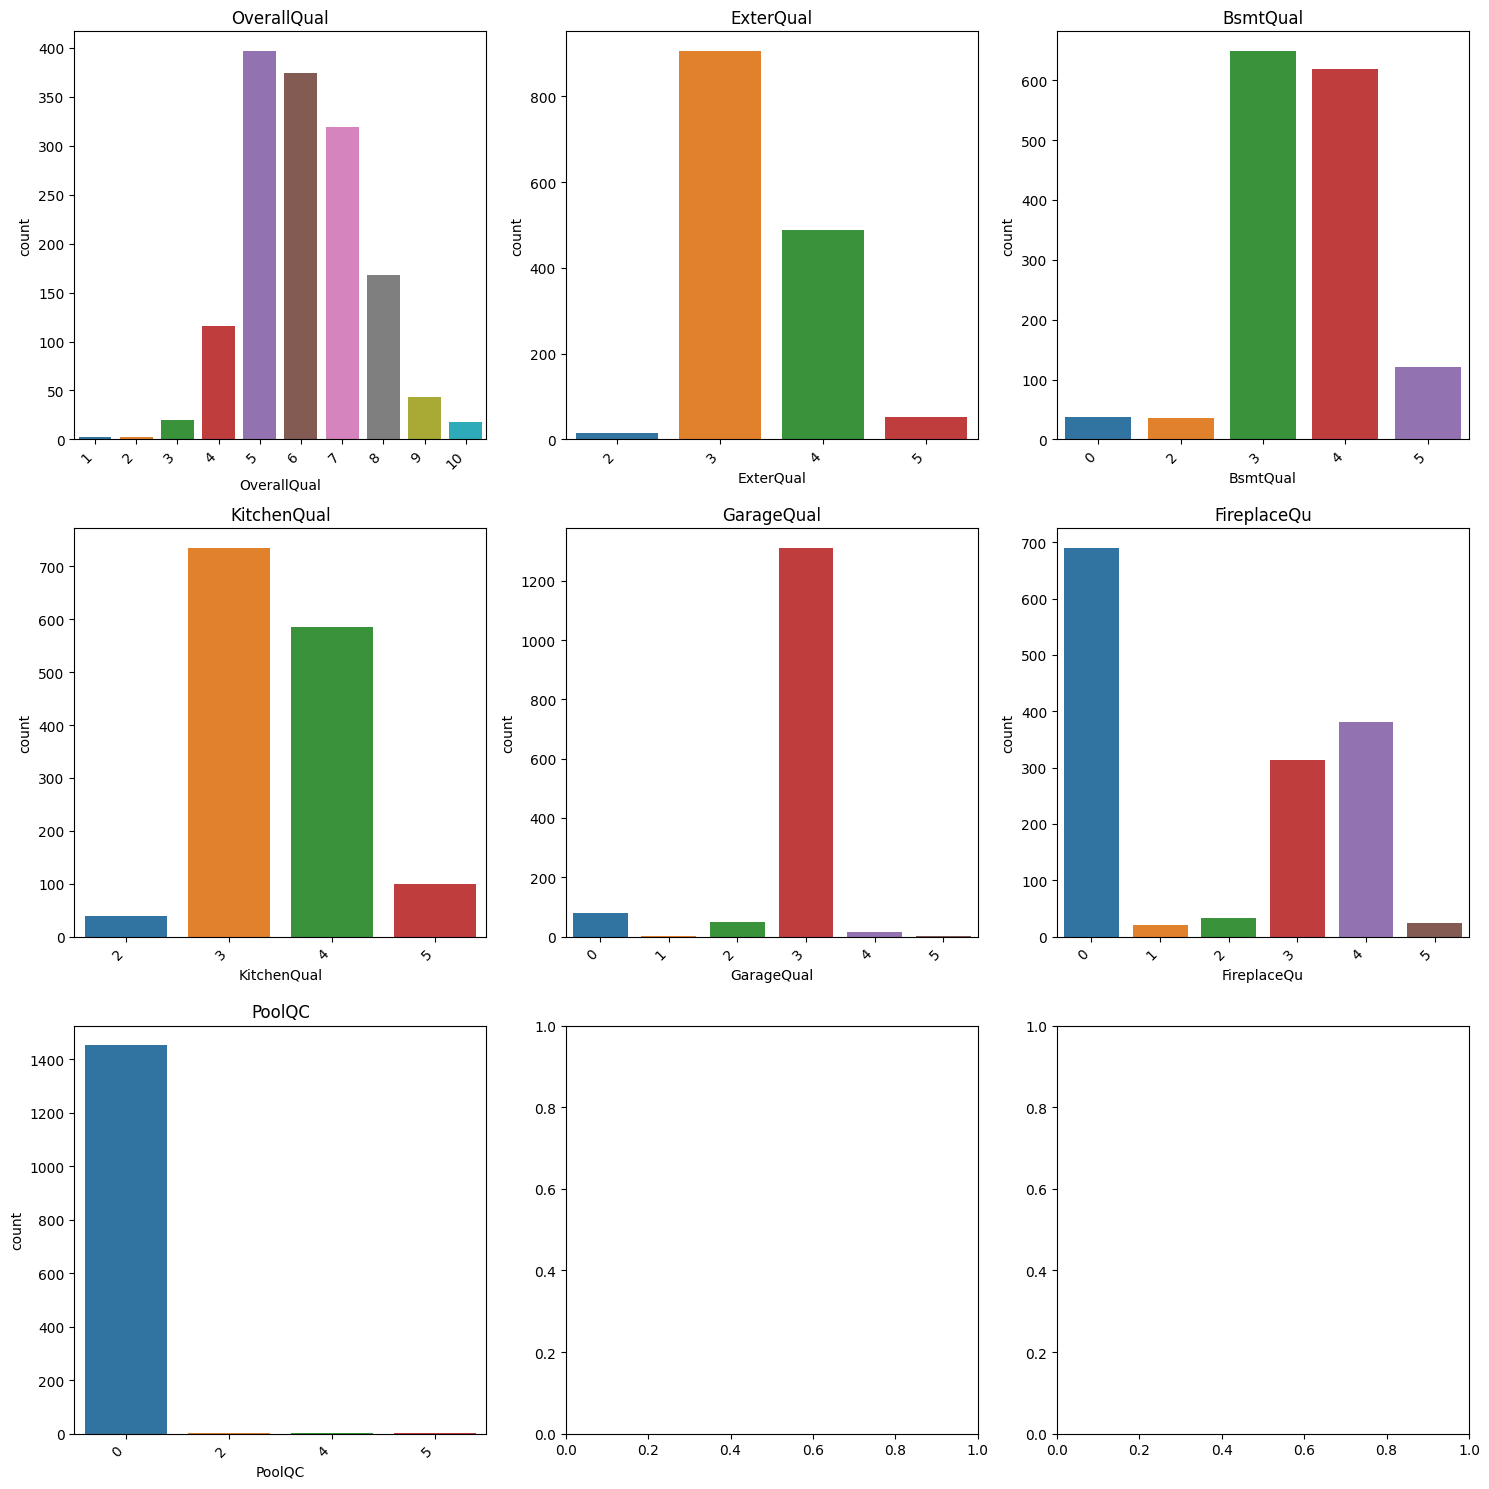

In [81]:
fig, axes = plt.subplots(3,3,figsize=(15,15))

columns = ['OverallQual','ExterQual','BsmtQual','KitchenQual','GarageQual','FireplaceQu','PoolQC']

for i, col in enumerate(columns):
    ax =axes[i//3,i%3] #i//3决定放哪一行，i%3决定放哪一列
    sns.countplot(x=col, data=df_train, ax=ax)
    ax.set_title(col)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')

plt.tight_layout()
plt.show()

整体质量非常重要，而且比其他变量更细致。外部质量也很重要，但与整体质量有很高的相关性（0.73）。厨房质量似乎也是要保持的，因为所有的房子都有厨房，而且在某些物质上存在差异。车库质量似乎没有太大区别，因为大多数车库都有Q3。壁炉质量在高相关性列表中，并在重要变量列表中。PoolQC非常稀疏（在这个规模上甚至无法看到13个池）。稍后我将讨论如何创建一个“has pool”变量



### 建筑类别变量

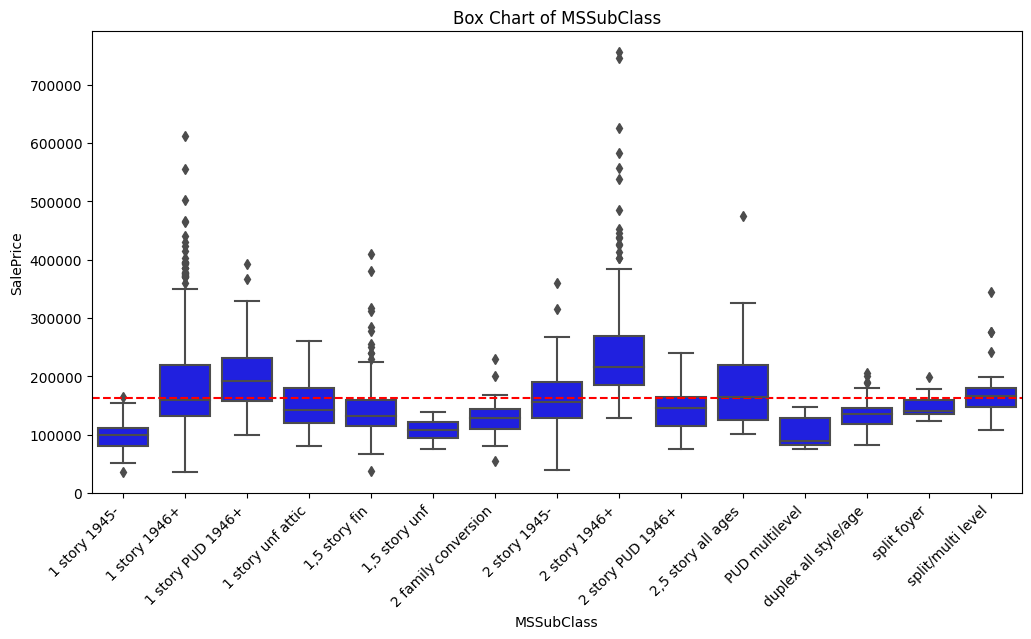

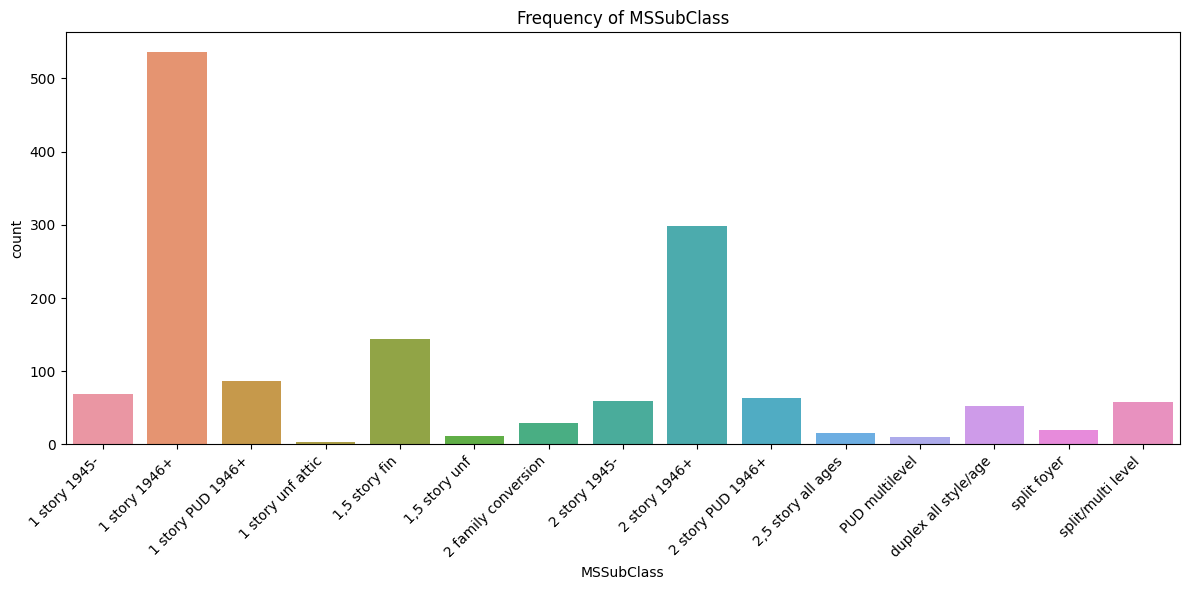

In [82]:
plt.figure(figsize=(12,6))
sns.boxplot(x='MSSubClass', y='SalePrice', data=df_train.dropna(subset=['SalePrice']), color='blue')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=df_train['SalePrice'].median(), color='red', linestyle='--')
plt.title('Box Chart of MSSubClass')

plt.figure(figsize=(12,6))
sns.countplot(x='MSSubClass', data=df_train)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of MSSubClass')

plt.tight_layout()
plt.show()

### 车库变量

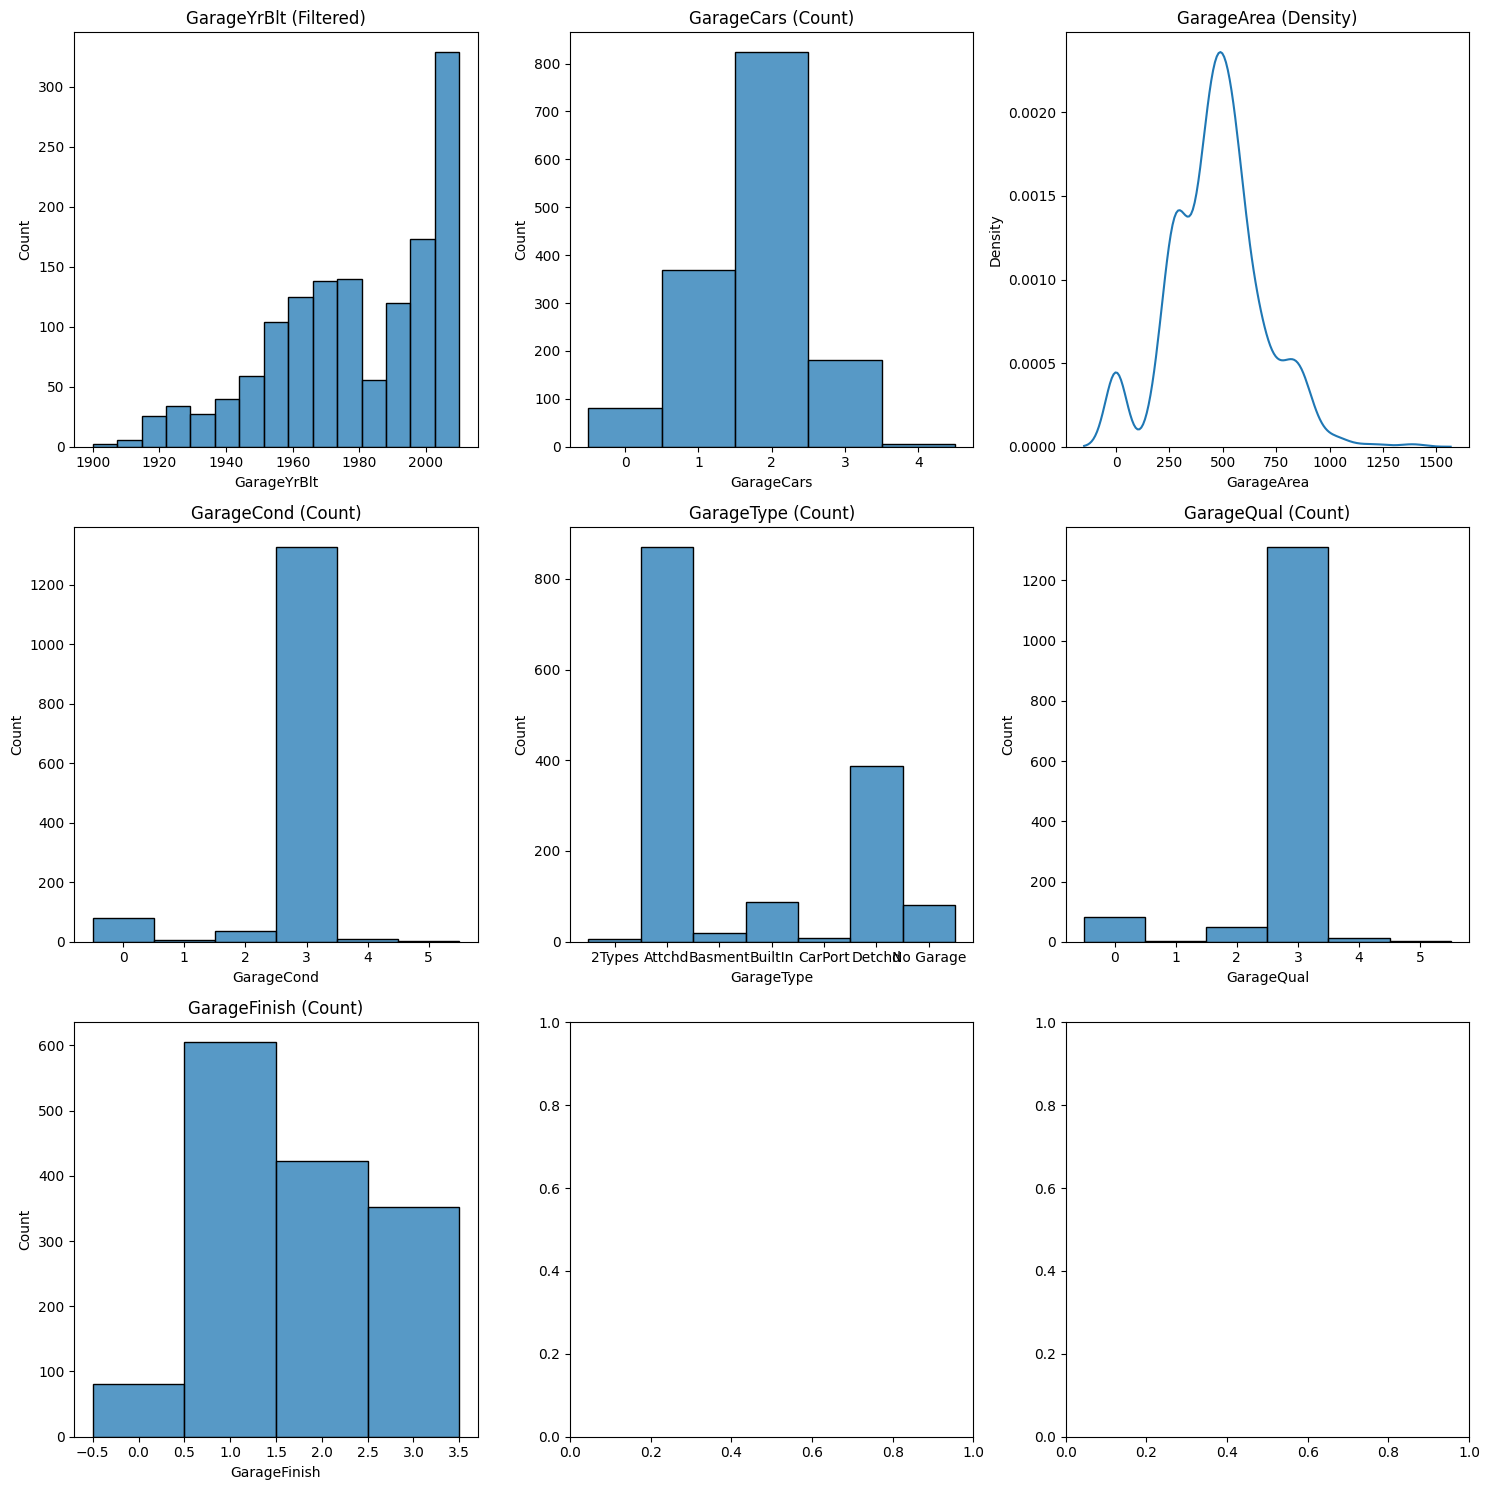

In [83]:
# 创建图形和子图布局
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

sns.histplot(data=df_train[df_train['GarageCars']!=0], x='GarageYrBlt',kde=False,ax=axes[0])
sns.histplot(data=df_train,x='GarageCars',discrete=True,ax=axes[1])
sns.kdeplot(data=df_train, x='GarageArea', ax=axes[2])  
sns.histplot(data=df_train, x='GarageCond', discrete=True, ax=axes[3])
sns.histplot(data=df_train, x='GarageType', discrete=True, ax=axes[4])
sns.histplot(data=df_train, x='GarageQual', discrete=True, ax=axes[5])
sns.histplot(data=df_train, x='GarageFinish', discrete=True, ax=axes[6])

# 设置标题
axes[0].set_title('GarageYrBlt (Filtered)')
axes[1].set_title('GarageCars (Count)')
axes[2].set_title('GarageArea (Density)')
axes[3].set_title('GarageCond (Count)')
axes[4].set_title('GarageType (Count)')
axes[5].set_title('GarageQual (Count)')
axes[6].set_title('GarageFinish (Count)')

plt.tight_layout()
plt.show()

GarageCars和GarageArea是高度相关的。在这里，GarageQual和GarageCond似乎也高度相关，并且都由level =3主导。

### 地下室变量

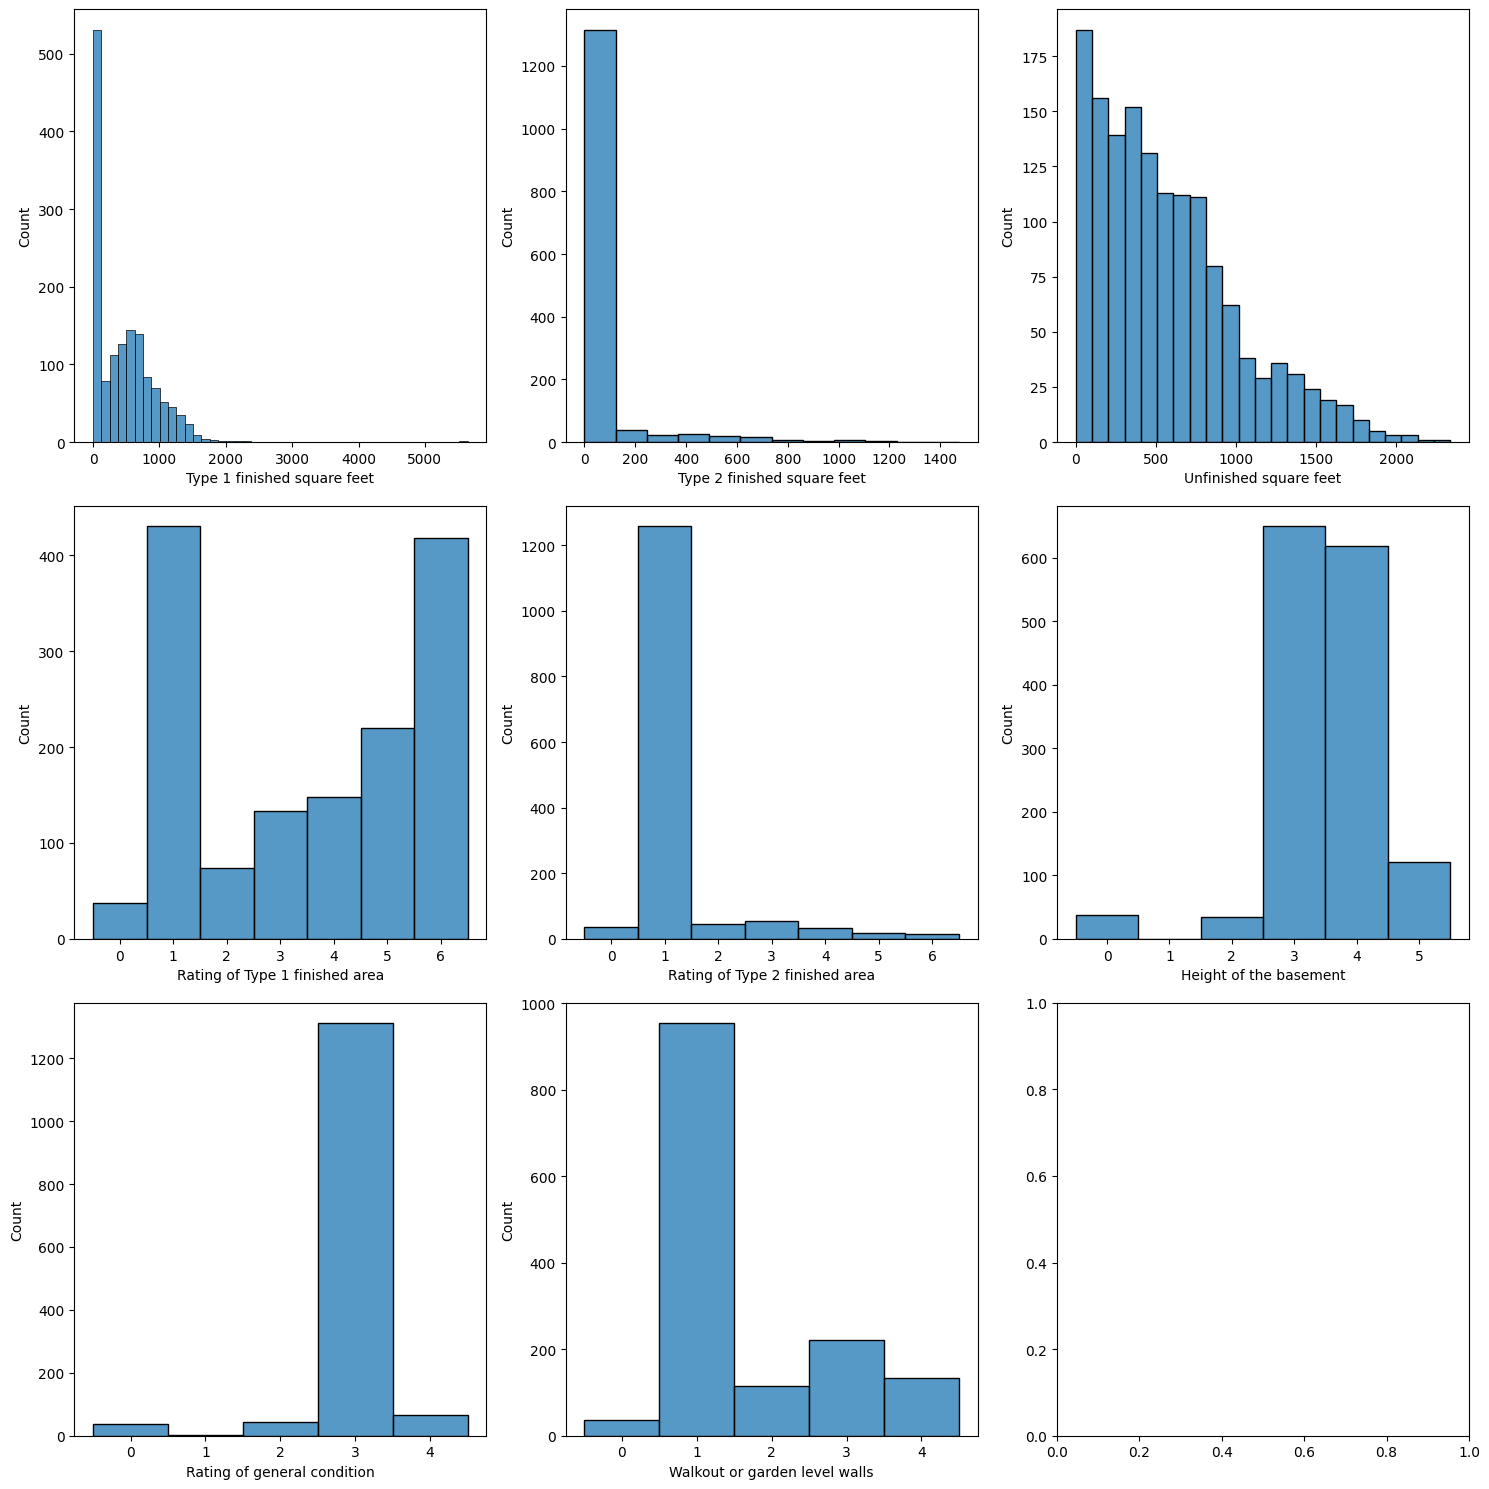

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()# 3*3的2维数组转成1维数组这样可以通过索引访问每个子图

# 绘制各个子图
sns.histplot(data=df_train, x='BsmtFinSF1', kde=False, ax=axes[0])  # b1
axes[0].set_xlabel('Type 1 finished square feet')

sns.histplot(data=df_train, x='BsmtFinSF2', kde=False, ax=axes[1])  # b2
axes[1].set_xlabel('Type 2 finished square feet')

sns.histplot(data=df_train, x='BsmtUnfSF', kde=False, ax=axes[2])  # b3
axes[2].set_xlabel('Unfinished square feet')

sns.histplot(data=df_train, x='BsmtFinType1', discrete=True, ax=axes[3])  # b4
axes[3].set_xlabel('Rating of Type 1 finished area')

sns.histplot(data=df_train, x='BsmtFinType2', discrete=True, ax=axes[4])  # b5
axes[4].set_xlabel('Rating of Type 2 finished area')

sns.histplot(data=df_train, x='BsmtQual', discrete=True, ax=axes[5])  # b6
axes[5].set_xlabel('Height of the basement')

sns.histplot(data=df_train, x='BsmtCond', discrete=True, ax=axes[6])  # b7
axes[6].set_xlabel('Rating of general condition')

sns.histplot(data=df_train, x='BsmtExposure', discrete=True, ax=axes[7])  # b8
axes[7].set_xlabel('Walkout or garden level walls')


# 调整布局，使得标签不重叠
plt.tight_layout()
plt.show()

# 四、特征工程

## 1.浴室变量
浴室有4个变量。单独看这些变量不是很重要。假设如果把它们合并成一个变量，作用或许会更大。
A half-bath也被称为化妆间或客用浴室，只有四个主要浴室组件中的两个——通常是马桶和水槽。”因此也将一半的浴室算作一半。

In [85]:
df_train['TotBathrooms']=df_train['FullBath']+(df_train['HalfBath']*0.5)+df_train['BsmtFullBath']+(df_train['BsmtHalfBath']*0.5)

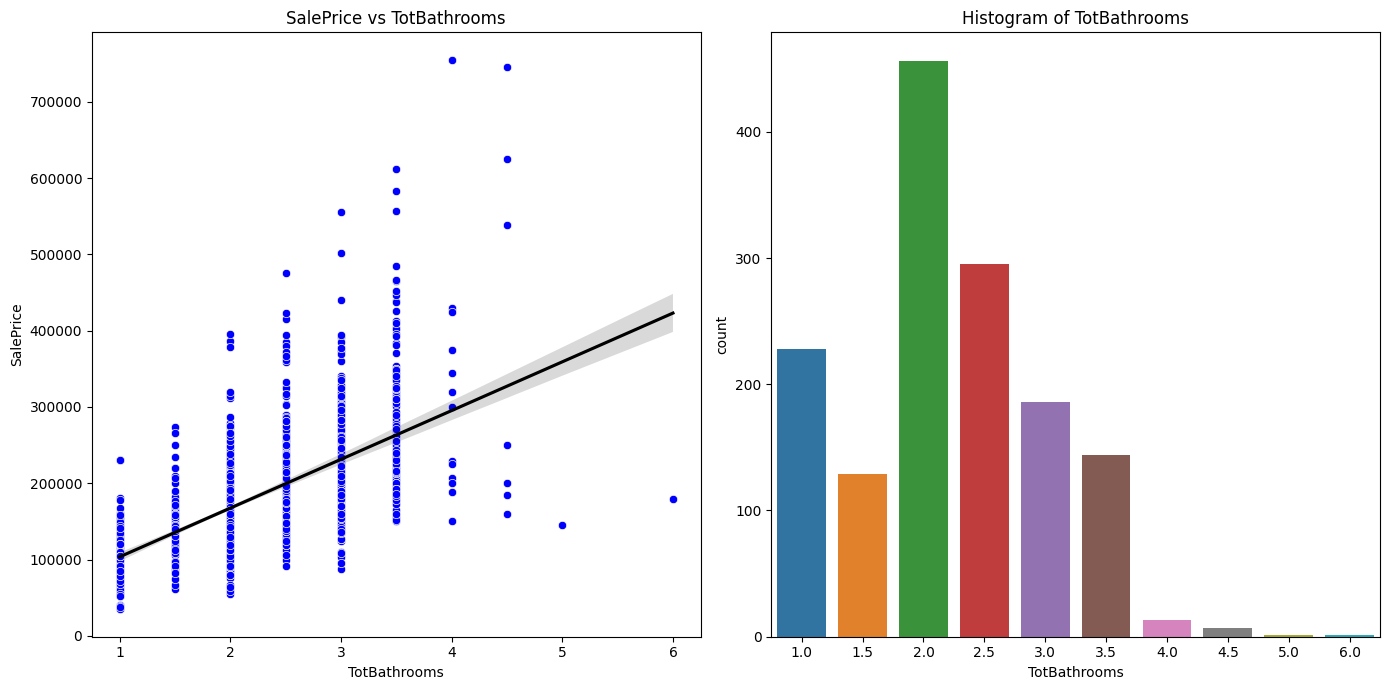

In [86]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.scatterplot(data=df_train[df_train['SalePrice'].notna()], x='TotBathrooms', y='SalePrice', color='blue', ax=axes[0])
sns.regplot(data=df_train[df_train['SalePrice'].notna()], x='TotBathrooms', y='SalePrice', scatter=False, ax=axes[0], color='black')
# 设置y轴刻度
# axes[0].yaxis.set_major_locator(plt.MultipleLocator(100000))  # 设置y轴的间隔
# axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))  # 设置y轴的标签格式为千位分隔符
axes[0].set_title('SalePrice vs TotBathrooms')

# 第二个图：TotBathrooms 的直方图
sns.countplot(data=df_train, x='TotBathrooms', ax=axes[1])
axes[1].set_title('Histogram of TotBathrooms')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

## 2.房龄变量
3个变量与房子的年龄有关；YearBlt， YearRemodAdd和YearSold。如果没有翻修，YearRemodAdd默认为YearBuilt。我将使用YearRemodAdd和YearSold来确定Age。由于旧建筑的一部分会一直保留下来，只有部分房子被翻新，还将引入一个被改造的Yes/No变量。这应该被视为某种惩罚参数，表明如果年龄是基于重建日期，那么它可能比建造房屋的价值更低

In [87]:
df_train['Remod']=(df_train['YearBuilt'] != df_train['YearRemodAdd']).astype(int)

df_train['Age'] = df_train['YrSold'] - df_train['YearRemodAdd']

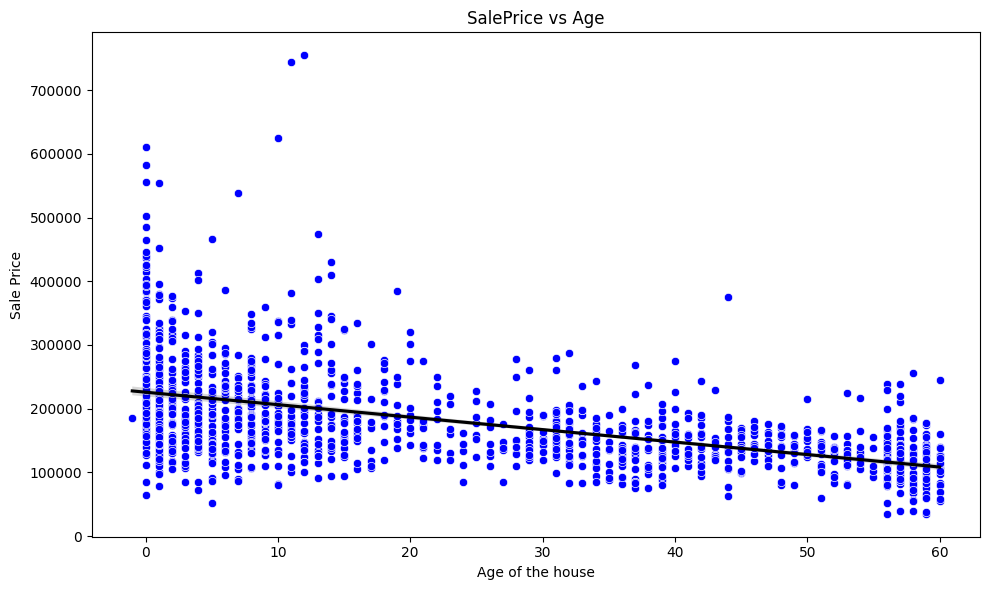

In [88]:
plt.figure(figsize=(10,6))

sns.scatterplot(data=df_train[df_train['SalePrice'].notna()], x='Age',y='SalePrice',color='blue')
sns.regplot(data=df_train[df_train['SalePrice'].notna()], x='Age', y='SalePrice', scatter=False, color='black')

plt.title('SalePrice vs Age')
plt.xlabel('Age of the house')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

In [89]:
df_train['SalePrice'].corr(df_train['Age'])
#图表显示了与年龄的负相关（旧房子更不值钱）。

-0.5090787380156294

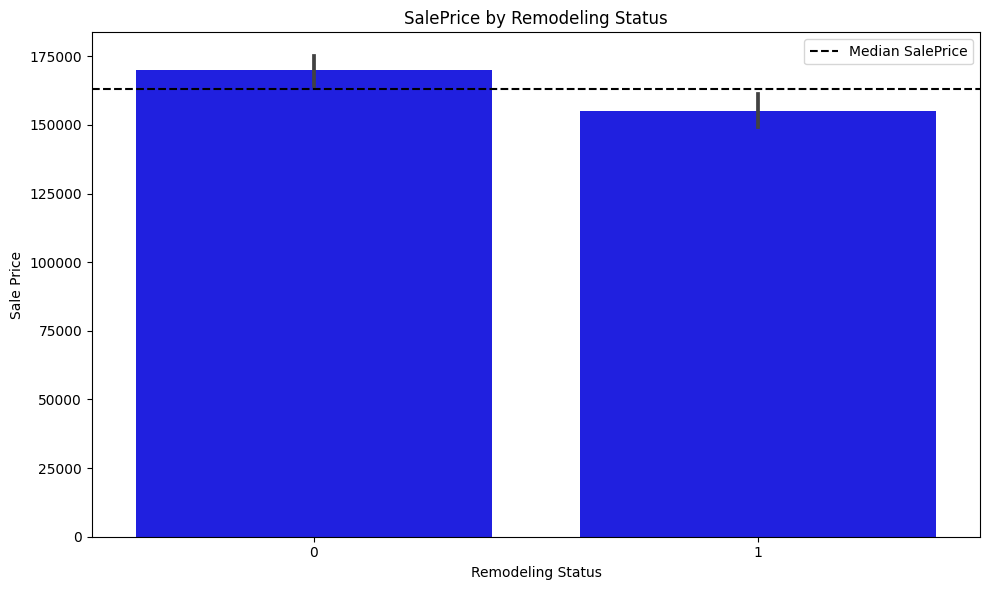

In [90]:
plt.figure(figsize=(10, 6))

# 绘制柱状图，使用中位数作为统计函数
sns.barplot(data=df_train[df_train['SalePrice'].notna()], x='Remod', y='SalePrice', estimator=np.median, color='blue')


# 添加中位数虚线
plt.axhline(y=df_train['SalePrice'].median(), color='black', linestyle='--', label="Median SalePrice")

# 设置标题和标签
plt.title('SalePrice by Remodeling Status')
plt.xlabel('Remodeling Status')
plt.ylabel('Sale Price')

# 显示图形
plt.tight_layout()
plt.legend()
plt.show()

# 图中可以看出改造后的房子更不值钱了

In [91]:
# 创建新列判断是否为新房
df_train['IsNew']=(df_train['YrSold'] == df_train['YearBuilt']).astype(int)

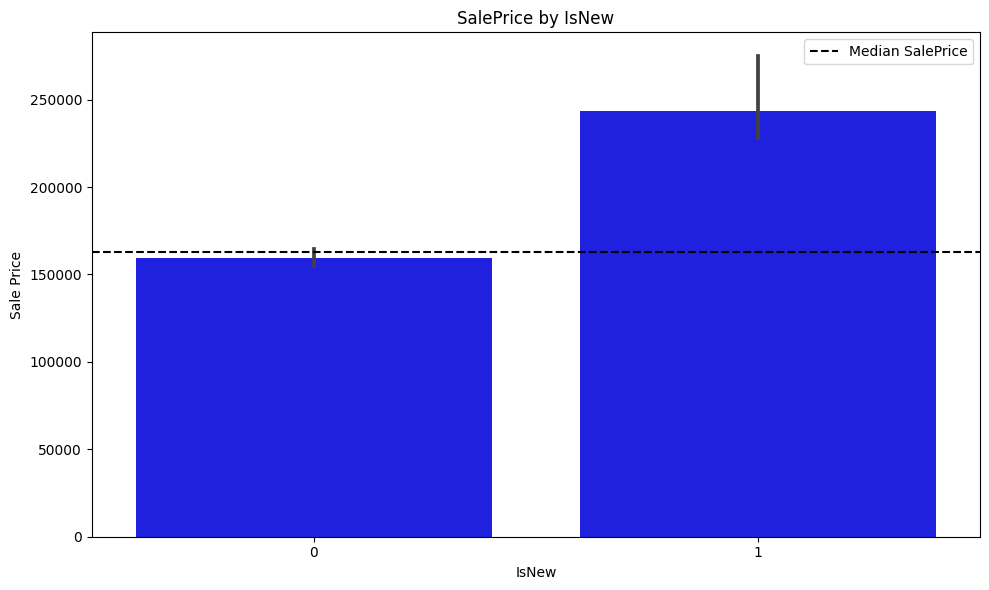

In [92]:
plt.figure(figsize=(10, 6))

# 绘制柱状图，使用中位数作为统计函数
sns.barplot(data=df_train[df_train['SalePrice'].notna()], x='IsNew', y='SalePrice', estimator=np.median, color='blue')

# 添加中位数虚线
plt.axhline(y=df_train['SalePrice'].median(), color='black', linestyle='--', label="Median SalePrice")

# 设置标题和标签
plt.title('SalePrice by IsNew')
plt.xlabel('IsNew')
plt.ylabel('Sale Price')

# 显示图形
plt.tight_layout()
plt.legend()
plt.show()

In [93]:
df_train['YrSold'] = df_train['YrSold'].astype('category')

## 3.邻里划分

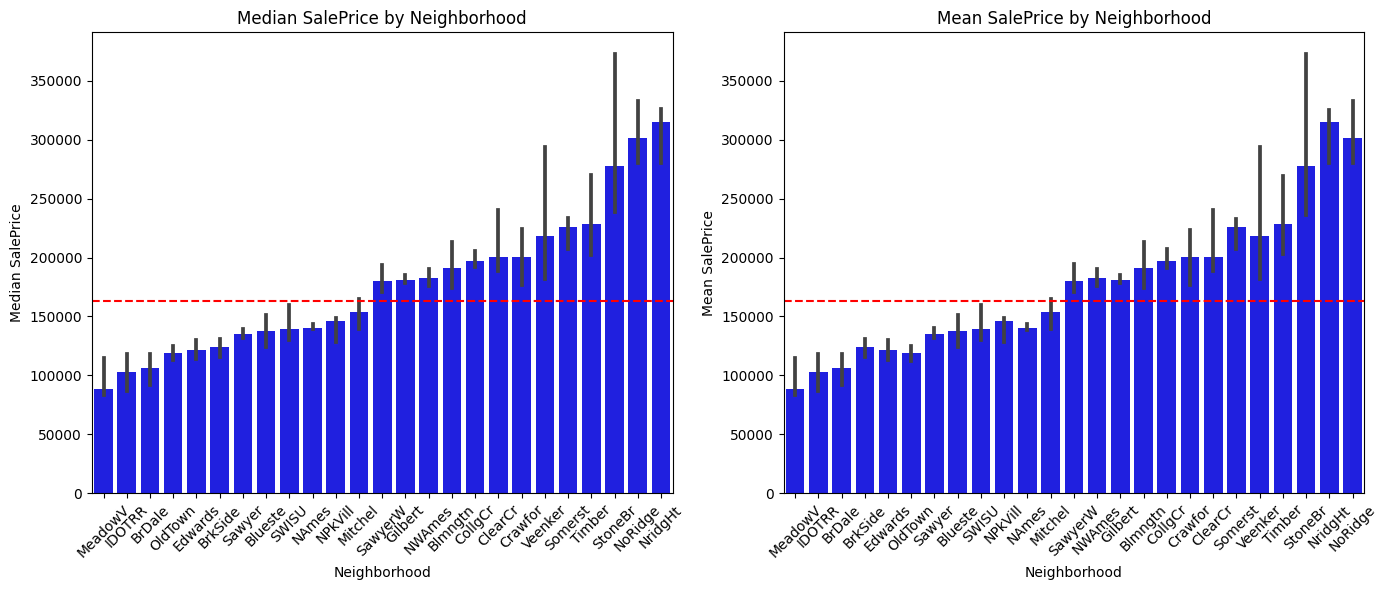

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 绘制中位数柱状图
sns.barplot(data=df_train[df_train['SalePrice'].notna()], x='Neighborhood', y='SalePrice', estimator=np.median, ax=axes[0], color='blue', order=df_train.groupby('Neighborhood')['SalePrice'].median().sort_values().index)
axes[0].axhline(y=df_train['SalePrice'].median(), color='red', linestyle='--')
axes[0].set_title('Median SalePrice by Neighborhood')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Median SalePrice')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df_train[df_train['SalePrice'].notna()], x='Neighborhood', y='SalePrice', estimator=np.median, ax=axes[1], color='blue', order=df_train.groupby('Neighborhood')['SalePrice'].mean().sort_values().index)
axes[1].axhline(y=df_train['SalePrice'].median(), color='red', linestyle='--')
axes[1].set_title('Mean SalePrice by Neighborhood')
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Mean SalePrice')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [95]:
df_train['NeighRich'] = 1
df_train.loc[df_train['Neighborhood'].isin(['StoneBr', 'NridgHt', 'NoRidge']), 'NeighRich'] = 2
df_train.loc[df_train['Neighborhood'].isin(['MeadowV', 'IDOTRR', 'BrDale']), 'NeighRich'] = 0

In [96]:
df_train['NeighRich'].value_counts()

NeighRich
1    1247
2     143
0      70
Name: count, dtype: int64

In [97]:
## 总居住空间

df_train['TotalSqFeet']=df_train['GrLivArea']+df_train['TotalBsmtSF']

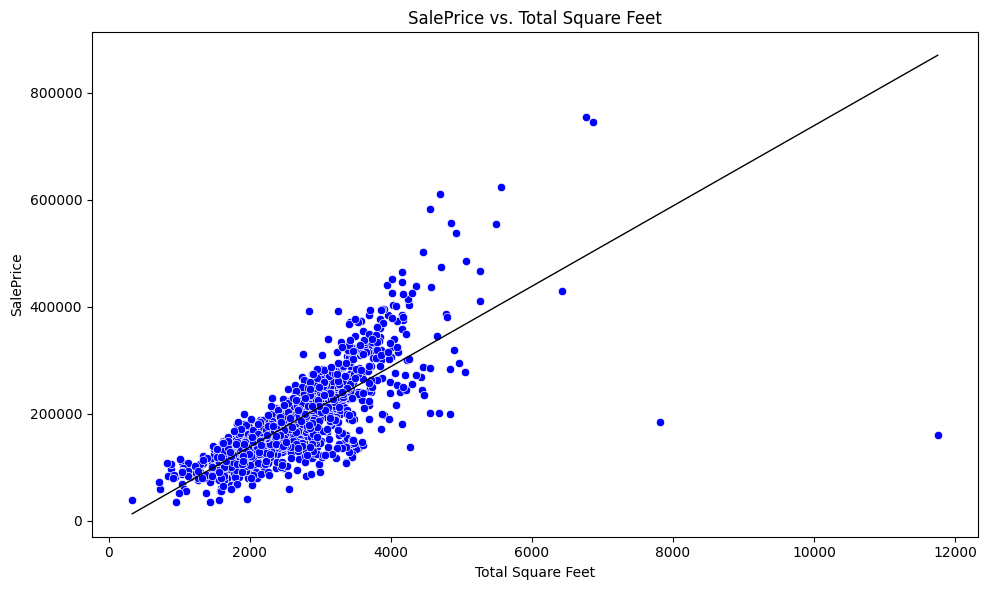

In [98]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='TotalSqFeet', y='SalePrice', color='blue')

# 添加线性回归拟合曲线
sns.regplot(data=df_train, x='TotalSqFeet', y='SalePrice', scatter=False, color='black', line_kws={'lw': 1}, ci=None)

# 显示图形
plt.title('SalePrice vs. Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

In [99]:
df_train['SalePrice'].corr(df_train['TotalSqFeet'])

0.7789588289942263

In [100]:
# 图中有很明显的两个异常值将它去掉可以提升相关性
print(df_train['TotalSqFeet'].nlargest(2).index)
df_train.drop([524, 1299], inplace=True)
df_train['SalePrice'].corr(df_train['TotalSqFeet'])

Index([1298, 523], dtype='int64')


0.7786073111316709

## 4.门廊变量
下面，我列出了与门廊相关的变量:

WoodDeckSF：木甲板面积（以平方英尺计）

OpenPorchSF：以平方英尺为单位的开放式门廊区域

EnclosedPorch：以平方英尺计的封闭式门廊面积

3SsnPorch：三季门廊面积，以平方英尺计

ScreenPorch：屏廊面积（以平方英尺计）

门廊是房子外面有遮蔽的地方，木甲板是没有遮蔽的。因此，我把WoodDeckSF单独留下，只合并4个门廊变量。

In [101]:
df_train['TotalPorchSF'] = df_train['OpenPorchSF']+df_train['EnclosedPorch']+df_train['3SsnPorch']+df_train['ScreenPorch']

In [102]:
df_train['SalePrice'].corr(df_train['TotalPorchSF'])

0.19609887100553702

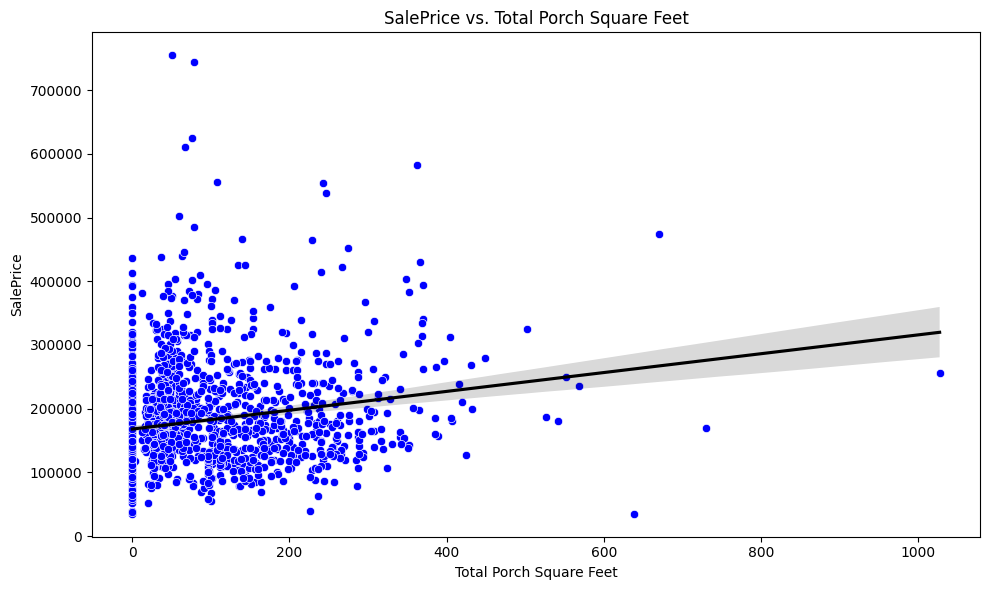

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train[df_train['SalePrice'].notna()], x='TotalPorchSF', y='SalePrice', color='blue')

# 添加线性回归拟合曲线
sns.regplot(data=df_train[df_train['SalePrice'].notna()], x='TotalPorchSF', y='SalePrice', scatter=False, color='black')

# 显示图形
plt.title('SalePrice vs. Total Porch Square Feet')
plt.xlabel('Total Porch Square Feet')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

# 五、为建模准备数据

## 1.剔除高相关变量
根据相关性矩阵剔除高度相关的两个变量（见之前）。例如：GarageCars和GarageArea的相关性为0.89。选择删除与SalePrice相关性最低的变量（即与SalePrice相关性为0.62的GarageArea）。GarageCars的销售价格相关性为0.64)。

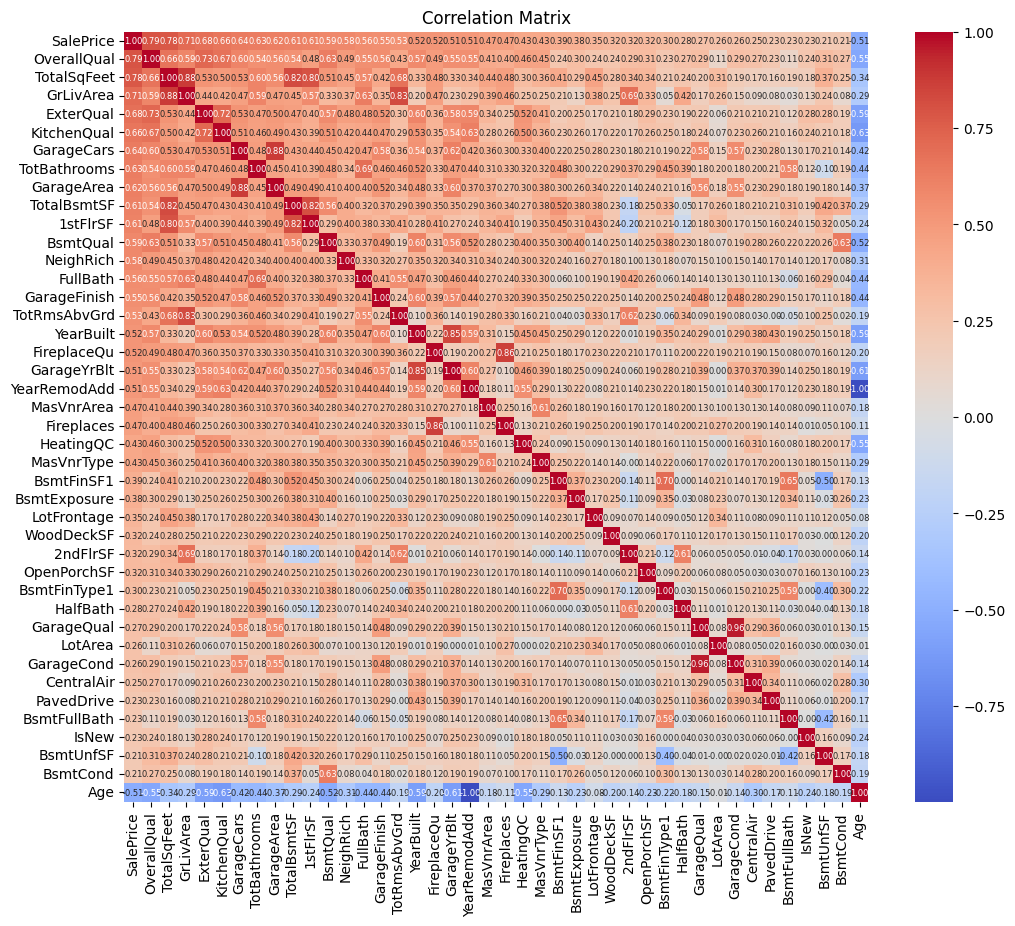

In [104]:
df_numeric=df_train.select_dtypes(include=['number'])
corr_matrix=df_numeric.corr()

corr_sorted = corr_matrix['SalePrice'].sort_values(ascending = False)
corr_high = corr_sorted[corr_sorted.abs()>0.2].index
corr_num_high = corr_matrix.loc[corr_high, corr_high]

plt.figure(figsize=(12,10))
sns.heatmap(corr_num_high,annot=True,cmap='coolwarm',fmt='.2f',annot_kws={'size':6},cbar=True,
            xticklabels=corr_num_high.columns,
           yticklabels=corr_num_high.columns)
plt.title('Correlation Matrix')
plt.show()

In [105]:
# YearRemodAdd KitchenQual
# GarageYrBlt YearBuilt
# GarageArea GarageCars
# GarageCond GarageQual
# TotalBSmtSF TotalSqFeet
# TotalRmsAbvGrd GrLivArea
# BsmtFinSF1 BsmtFinType1
drop_vars = ['YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotalBsmtSF', 'TotRmsAbvGrd','BsmtFinSF1']

df_train = df_train.drop(columns=drop_vars)

## 2.删除异常值
目前只是手动删除两个非常大的低售价的房子。

## 3.预处理预测变量

In [106]:
numeric_var_names=list(df_train.select_dtypes(include=['number']).columns)

exclude_columns = ['MSSubClass', 'MoSold', 'YrSold', 'SalePrice', 'OverallQual', 'OverallCond']
numeric_var_names = [col for col in numeric_var_names if col not in exclude_columns]
numeric_var_names.extend(['Age','TotalPorchSF','TotBathrooms','TotalSqFeet'])

train_numeric = df_train[numeric_var_names]

train_factors = df_train.drop(columns=numeric_var_names)
train_factors = train_factors.drop(columns=['SalePrice'])

print(f'There are {len(train_numeric.columns)} numeric variables, and {len(train_factors.columns)} factor variables')

There are 55 numeric variables, and 27 factor variables


### 偏度和标准化

In [107]:
# 偏度矫正
from scipy.stats import skew

for i in range(train_numeric.shape[1]):
    if abs(skew(train_numeric.iloc[:, i])) > 0.8:
        train_numeric.iloc[:, i] = np.log(train_numeric.iloc[:, i] + 1)

In [108]:
# 标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#保证DFnorm和DFnumeric数据类型一致
train_numeric = pd.DataFrame(scaler.fit_transform(train_numeric), columns=train_numeric.columns, index=train_numeric.index)
print(train_numeric.shape)

(1458, 55)


### 独热编码

In [109]:
# DFdummies = pd.get_dummies(DFfactors, drop_first=False)
# print(DFdummies.shape)

#后面还应该检查并移除了那些在训练集和测试集中都没有任何数据（即全为0的列）
#和出现次数过少的列 并把训练集和测试集合并成一个新的数据框

In [110]:
#combined_train = pd.concat([train_numeric, train_factors], axis=1)

In [111]:
saleprice_skew = skew(df_train['SalePrice'])
saleprice_skew

1.884921293060057

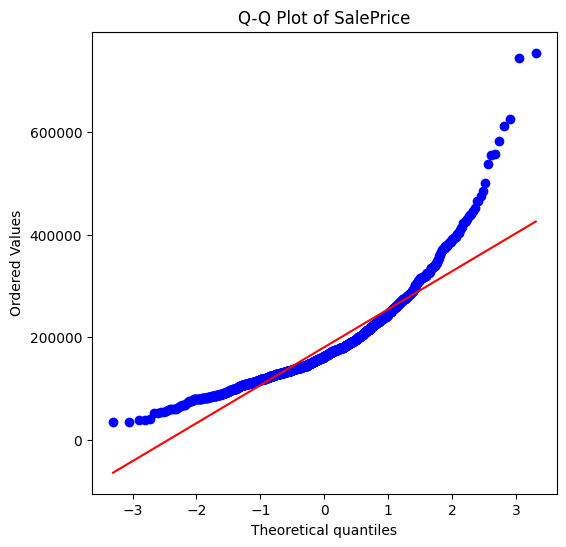

In [112]:
from scipy.stats import skew, probplot
plt.figure(figsize=(6,6))
probplot(df_train['SalePrice'], dist='norm', plot=plt)
plt.title('Q-Q Plot of SalePrice')
plt.show()

从偏度看出数据呈现的是右偏， 从qq图看出数据不服从正态分布，可以对该列进行取对数操作

In [113]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

skew(df_train['SalePrice'])
# 结果上看明显好了很多

0.12153170995036593

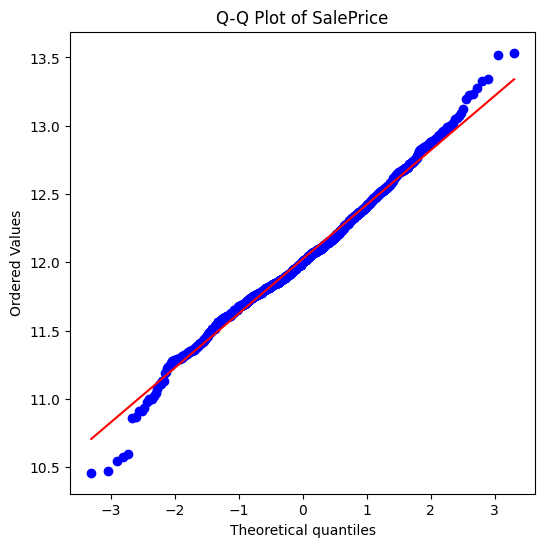

In [114]:
plt.figure(figsize=(6,6))
probplot(df_train['SalePrice'], dist='norm', plot=plt)
plt.title('Q-Q Plot of SalePrice')
plt.show()

# 六、 测试集处理

## 1.处理缺失值

In [115]:
miss_tot = df_test.isnull().sum().sort_values(ascending=False)
miss_precent = (miss_tot / len(df_test)).sort_values(ascending=False)


missing_data = pd.concat([miss_tot, miss_precent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,1459,1.000000
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
MasVnrType,894,0.612748
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageQual,78,0.053461
GarageYrBlt,78,0.053461


In [116]:
#泳池数量为0的填充为None
df_test['PoolQC']=df_test['PoolQC'].fillna('None')
#创建字典用于映射
qualities = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
#使用replace方法将列中的值转换为证书类型
df_test['PoolQC']=df_test['PoolQC'].replace(qualities).astype(int)

df_test['MiscFeature']=df_test['MiscFeature'].fillna('None')
df_test['MiscFeature'] = df_test['MiscFeature'].astype('category')

df_test['Alley']=df_test['Alley'].fillna('None')

df_test['MasVnrType'].fillna('None',inplace=True)
mansonry = {'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2}
df_test['MasVnrType'] = df_test['MasVnrType'].map(mansonry)

df_test['FireplaceQu']=df_test['FireplaceQu'].fillna('None')
qualities = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df_test['FireplaceQu']=df_test['FireplaceQu'].replace(qualities).astype(int)
df_test['FireplaceQu']=df_test['FireplaceQu'].fillna('None')
qualities = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df_test['FireplaceQu']=df_test['FireplaceQu'].replace(qualities).astype(int)

df_test['Fence']=df_test['Fence'].fillna('None')
df_test['Fence'] = pd.Categorical(df_test['Fence'])

#遍历每一行 将LotFrontage的缺失值按照 每一个Neighborhood分组的LotFrontage值的中位数进行填充
for i in range(len(df_test)):
    if pd.isna(df_test.loc[i, 'LotFrontage']):
        neighborhood = df_test.loc[i, 'Neighborhood']
        median_value = np.median(df_test.loc[df_test['Neighborhood'] == neighborhood, 'LotFrontage'].dropna())
        df_test.loc[i,'LotFrontage'] = int(median_value)

# 处理缺失值GarageQual
df_test['GarageQual'] = df_test['GarageQual'].fillna('None')
# 使用映射字典将 'GarageQual' 列中的值替换为整数
df_test['GarageQual'] = df_test['GarageQual'].map(qualities)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_test['YearBuilt'])
df_test['GarageFinish'] = df_test['GarageFinish'].fillna('None')
Finish = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}
df_test['GarageFinish']=df_test['GarageFinish'].map(Finish)
# 处理缺失值GarageCond
df_test['GarageCond'] = df_test['GarageCond'].fillna('None')
# 使用映射字典将 'GarageQual' 列中的值替换为整数
df_test['GarageCond'] = df_test['GarageCond'].map(qualities)
df_test['GarageType'] = df_test['GarageType'].fillna('No Garage')
df_test['GarageType'] = pd.Categorical(df_test['GarageType'])

df_test['BsmtCond'] = df_test['BsmtCond'].fillna('None')
df_test['BsmtCond'] = df_test['BsmtCond'].map(qualities)
df_test['BsmtQual'] = df_test['BsmtQual'].fillna('None')
df_test['BsmtQual'] = df_test['BsmtQual'].map(qualities)
exposure = {'None':0, 'No':'1', 'Mn':2, 'Av':3, 'Gd':4}
df_test['BsmtExposure'] = df_test['BsmtExposure'].fillna('None')
df_test['BsmtExposure'] = df_test['BsmtExposure'].map(exposure).astype(int)
FinType = {'None':0, 'Unf':'1', 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].fillna('None')
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].map(FinType).astype(int)
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].fillna('None')
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].map(FinType).astype(int)

df_test['MasVnrArea'].fillna(0,inplace=True)

df_test['MSZoning'].fillna(df_test['MSZoning'].mode()[0], inplace=True)
# Converting 'MSZoning' to a categorical type
df_test['MSZoning'] = df_test['MSZoning'].astype('category')

df_test['BsmtFullBath'].fillna(0, inplace=True)
df_test['BsmtHalfBath'].fillna(0, inplace=True)
df_test['TotalBsmtSF'].fillna(0, inplace=True)
df_test['BsmtUnfSF'].fillna(0, inplace=True)
df_test['BsmtFinSF2'].fillna(0, inplace=True)
df_test['BsmtFinSF1'].fillna(0, inplace=True)

df_test.drop(columns=['Utilities'], inplace=True)

most_frequent_value = df_test['Functional'].mode()[0]
df_test['Functional'].fillna(most_frequent_value, inplace=True)
# 替换 'Functional' 列中的不同值为整数
value_map = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
df_test['Functional'] = df_test['Functional'].map(value_map)


df_test['GarageArea'].fillna(0, inplace=True)

# 将 'KitchenQual' 列中的缺失值填充为最常出现的值 'TA'
df_test['KitchenQual'].fillna('TA', inplace=True)
# 替换 'KitchenQual' 列中的不同值为整数
df_test['KitchenQual'] = df_test['KitchenQual'].map(qualities)



df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0], inplace=True)
df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0], inplace=True)
# 将 'Exterior1st' 列转换为类别类型
df_test['Exterior1st'] = pd.Categorical(df_test['Exterior1st'])
df_test['Exterior2nd'] = pd.Categorical(df_test['Exterior2nd'])

df_test['SaleType'].fillna(df_test['SaleType'].mode()[0], inplace=True)

df_test['GarageCars'].fillna(0, inplace=True)

In [117]:
df_test['Foundation'] = df_test['Foundation'].astype('category')

df_test['Heating'] = df_test['Heating'].astype('category')
df_test['Heating'] = df_test['Heating'].astype('category')
heating_counts = df_test['Heating'].value_counts()



df_test['RoofStyle'] = df_test['RoofStyle'].astype('category')
df_test['RoofMatl'] = df_test['RoofMatl'].astype('category')

df_train['MoSold'] = df_train['MoSold'].astype('category')


In [118]:
df_test['Foundation'] = df_test['Foundation'].astype('category')
df_test['Heating'] = df_test['Heating'].astype('category')

central_air_map = {'N':0, 'Y':1}
df_test['CentralAir'] = df_test['CentralAir'].map(central_air_map)
df_test['RoofStyle'] = df_test['RoofStyle'].astype('category')
df_test['RoofMatl'] = df_test['RoofMatl'].astype('category')
df_test['LandContour'] = df_test['LandContour'].astype('category')

land_slope = {'Sev':0, 'Mod':1, 'Gtl':2}
df_test['LandSlope'] = df_test['LandSlope'].map(land_slope)
df_test['BldgType'] = df_test['BldgType'].astype('category')
df_test['HouseStyle'] = df_test['HouseStyle'].astype('category')
df_test['Neighborhood'] = df_test['Neighborhood'].astype('category')
df_test['Condition1'] = df_test['Condition1'].astype('category')
df_test['Condition2'] = df_test['Condition2'].astype('category')
street = {'Grvl':0, 'Pave':1}
df_test['Street'] = df_test['Street'].map(street)
paved = {'N':0, 'P':1, 'Y':2}
df_test['PavedDrive'] = df_test['PavedDrive'].map(paved)
df_test['MSSubClass'] = df_test['MSSubClass'].astype('str')


df_test['HeatingQC'] = df_test['HeatingQC'].map(qualities)

df_test['Exterior1st'] = df_test['Exterior1st'].astype('category')
df_test['Exterior2nd'] = df_test['Exterior2nd'].astype('category')
df_test['ExterQual'] = df_test['ExterQual'].map(qualities)
df_test['ExterCond'] = df_test['ExterCond'].map(qualities)
df_test['SaleType'] = df_test['SaleType'].astype('category')
df_test['SaleCondition'] = df_test['SaleCondition'].astype('category')


ms_subclass = {
    '20': '1 story 1946+', 
    '30': '1 story 1945-', 
    '40': '1 story unf attic', 
    '45': '1,5 story unf', 
    '50': '1,5 story fin', 
    '60': '2 story 1946+', 
    '70': '2 story 1945-', 
    '75': '2,5 story all ages', 
    '80': 'split/multi level', 
    '85': 'split foyer', 
    '90': 'duplex all style/age', 
    '120': '1 story PUD 1946+', 
    '150': '1,5 story PUD all', 
    '160': '2 story PUD 1946+', 
    '180': 'PUD multilevel', 
    '190': '2 family conversion'
}

# 用 map() 将 'MSSubClass' 列的值替换为更具描述性的标签
df_test['MSSubClass'] = df_test['MSSubClass'].replace(ms_subclass)# 注意map是字符串匹配 所以没有转成category
df_test['MSSubClass'] = df_test['MSSubClass'].astype('category')

In [119]:
miss_tot = df_test.isnull().sum().sort_values(ascending=False)
miss_precent = (miss_tot / len(df_test)).sort_values(ascending=False)


missing_data = pd.concat([miss_tot, miss_precent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,1459,1.0
KitchenAbvGr,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
BedroomAbvGr,0,0.0


## 2.特征工程

In [120]:
df_test['TotBathrooms']=df_test['FullBath']+(df_test['HalfBath']*0.5)+df_test['BsmtFullBath']+(df_test['BsmtHalfBath']*0.5)


df_test['Remod']=(df_test['YearBuilt'] != df_test['YearRemodAdd']).astype(int)

df_test['Age'] = df_test['YrSold'] - df_test['YearRemodAdd']

df_test['IsNew']=(df_test['YrSold'] == df_test['YearBuilt']).astype(int)

df_test['YrSold'] = df_test['YrSold'].astype('category')
df_test['NeighRich'] = 1
df_test.loc[df_test['Neighborhood'].isin(['StoneBr', 'NridgHt', 'NoRidge']), 'NeighRich'] = 2
df_test.loc[df_test['Neighborhood'].isin(['MeadowV', 'IDOTRR', 'BrDale']), 'NeighRich'] = 0
df_test['TotalSqFeet']=df_test['GrLivArea']+df_test['TotalBsmtSF']
df_test.drop([524, 1299], inplace=True)
df_test['SalePrice'].corr(df_test['TotalSqFeet'])
df_test['TotalPorchSF'] = df_test['OpenPorchSF']+df_test['EnclosedPorch']+df_test['3SsnPorch']+df_test['ScreenPorch']


## 3.准备数据

In [121]:
drop_vars = ['YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotalBsmtSF', 'TotRmsAbvGrd','BsmtFinSF1']

df_test = df_test.drop(columns=drop_vars)

numeric_var_names=list(df_test.select_dtypes(include=['number']).columns)

exclude_columns = ['MSSubClass', 'MoSold', 'YrSold', 'SalePrice', 'OverallQual', 'OverallCond']
numeric_var_names = [col for col in numeric_var_names if col not in exclude_columns]
numeric_var_names.extend(['Age','TotalPorchSF','TotBathrooms','TotalSqFeet'])

test_numeric = df_test[numeric_var_names]

test_factors = df_test.drop(columns=numeric_var_names)
test_factors = test_factors.drop(columns=['SalePrice'])

print(f'There are {len(test_numeric.columns)} numeric variables, and {len(test_factors.columns)} factor variables')

There are 55 numeric variables, and 27 factor variables


In [122]:
for i in range(test_numeric.shape[1]):
    if abs(skew(test_numeric.iloc[:, i])) > 0.8:
        test_numeric.iloc[:, i] = np.log(test_numeric.iloc[:, i] + 1)

scaler = StandardScaler()

test_numeric = pd.DataFrame(scaler.fit_transform(test_numeric), columns=test_numeric.columns, index=test_numeric.index)


类别不平衡的列均为分类变量，经排查大概率是在热编码的过程造成数据不平衡。解决方案是将数据集和训练集在特征工程步骤之后先进行合并，然后统一进行独热编码，然后再划分训练集和测试集进入建模步骤

In [123]:
# 1. 竖着合并 train_factors 和 test_factors
# ignore_index=True 确保合并后的 DataFrame 有一个全新的、从0开始的索引
combined_factors = pd.concat([train_factors, test_factors], axis=0, ignore_index=True)

# 2. 对合并后的数据进行哑变量处理
# get_dummies()会基于combined_factors中所有出现的类别来创建列，保证了特征的一致性
DFdummies = pd.get_dummies(combined_factors, drop_first=False)

In [124]:

# 计算每一列的和，并找出和小于10的列
few_ones = DFdummies.sum(axis=0) < 10

# 获取这些列的名称
columns_to_remove = DFdummies.columns[few_ones]

# 打印出这些列的名称
print("出现次数少于10的列名：")
print(columns_to_remove)

DFdummies = DFdummies.drop(columns=columns_to_remove, axis=1)

# 打印新数据框的维度（行数, 列数）
print(DFdummies.shape)


# 3. 再根据原始长度拆分为训练集和测试集
# 此时，train_dummies 和 test_dummies 的索引也都是从0开始
train_dummies_raw = DFdummies.iloc[:len(train_factors), :]
test_dummies_raw = DFdummies.iloc[len(train_factors):, :]

# 4. 关键步骤：重新设置索引以匹配 train_numeric 和 test_numeric
# 使用 .set_index() 方法，将 train_dummies_raw 的索引设置为 train_numeric 的原始索引
train_dummies = train_dummies_raw.set_index(train_numeric.index)
test_dummies = test_dummies_raw.set_index(test_numeric.index)

# 5. 横向合并分类变量和数值变量
# 由于索引现在完全匹配，concat() 可以完美对齐，不会再产生 NaN
train_DF = pd.concat([train_dummies, train_numeric], axis=1)
test_DF = pd.concat([test_dummies, test_numeric], axis=1)

出现次数少于10的列名：
Index(['MSSubClass_1 story unf attic', 'MSSubClass_1,5 story PUD all',
       'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery',
       'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe',
       'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin',
       'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
       'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_AsphShn', 'Exterior2nd_CBlock', 'Exterior2nd_Other',
       'Exterior2nd_Stone', 'Foundation_Wood', 'Heating_Floor', 'Heating_Grav',
       'Heating_OthW', 'Heating_Wall', 'Electrical_FuseP', 'Electrical_Mix',
       'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_TenC',
       'SaleType_Con', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth'],
      dtype='object')
(2915, 153)


In [125]:
train_DF = train_DF.loc[:, ~train_DF.columns.duplicated()]
test_DF = test_DF.loc[:, ~test_DF.columns.duplicated()]

# 七、建模

In [126]:
train1 = train_DF
test1 = test_DF

## 1.Lasso regression

In [127]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

np.random.seed(27042018)

y_train = df_train['SalePrice'].dropna()

alphas = np.arange(0.001, 0.1, 0.0005)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=27042018)
lasso_cv.fit(train1, y_train)

best_alpha = lasso_cv.alpha_
print('Best alpha(lambda:', best_alpha)

min_rmse = np.sqrt(np.min(lasso_cv.mse_path_.mean(axis=1)))
print('Min RMSE', min_rmse)

# 5. 变量重要性分析
coef = lasso_cv.coef_
vars_selected = np.sum(coef != 0)
vars_not_selected = np.sum(coef == 0)
print(f"Lasso uses {vars_selected} variables in its model, and did not select {vars_not_selected} variables.")

# 6. 预测和反归一化
lasso_pred = lasso_cv.predict(test1)
predictions_lasso = np.exp(lasso_pred)  # 反log变换
print(predictions_lasso[:6])

Best alpha(lambda: 0.001
Min RMSE 0.12359226262403442
Lasso uses 71 variables in its model, and did not select 133 variables.
[115797.24506308 163020.608358   184436.11751404 204798.82299429
 205178.19430599 174958.75546157]


## 2.XGBoost

In [128]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 定义参数网格字典
xgb_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [2, 3, 4, 5, 6],
    'gamma': [0],
    'colsample_bytree': [1],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [1]
}

# 假设 train1 和 all['SalePrice'] 是已准备好的训练数据
# 例如 train1 是特征数据集，all['SalePrice'] 是目标变量

# X_train = train1  # 特征数据
# y_train = df_train['SalePrice'].dropna()  # 目标变量

# # 设置 XGBoost 模型
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# # 设置网格搜索
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_grid, cv=5, verbose=1, n_jobs=-1)

# # 运行网格搜索
# grid_search.fit(X_train, y_train)

# # 输出最佳参数组合
# print("Best parameters found: ", grid_search.best_params_)


Max_depth=2 

eta=0.05

Min_child_weight=1

In [129]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_importance

# 假设 train1 和 test1 是你的特征数据集，all['SalePrice'] 是目标变量
label_train = df_train['SalePrice'].dropna()

# 将训练和测试数据转换为 DMatrix 格式
dtrain = xgb.DMatrix(data=train1, label=label_train)
dtest = xgb.DMatrix(data=test1)

# 设置默认的 XGBoost 参数
default_param = {
    'objective': 'reg:squarederror',  # 适用于回归任务
    'booster': 'gbtree',
    'eta': 0.05,
    'gamma': 0,
    'max_depth': 2,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1
}

# 使用交叉验证来选择最佳迭代次数
xgbcv = xgb.cv(
    params=default_param,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    early_stopping_rounds=10,
    stratified=False,
    verbose_eval=40,
    show_stdv=True
)

# 获取最佳迭代次数
best_iteration = xgbcv.shape[0] - 1  # 最佳的迭代次数
print(f"Best iteration: {best_iteration}")

[0]	train-rmse:0.38594+0.00458	test-rmse:0.38594+0.01869
[40]	train-rmse:0.17306+0.00334	test-rmse:0.18149+0.01615
[80]	train-rmse:0.13245+0.00359	test-rmse:0.14841+0.01717
[120]	train-rmse:0.11646+0.00295	test-rmse:0.13934+0.01690
[160]	train-rmse:0.10689+0.00248	test-rmse:0.13351+0.01671
[200]	train-rmse:0.10055+0.00227	test-rmse:0.13004+0.01667
[240]	train-rmse:0.09596+0.00217	test-rmse:0.12757+0.01638
[280]	train-rmse:0.09243+0.00220	test-rmse:0.12566+0.01581
[320]	train-rmse:0.08954+0.00216	test-rmse:0.12454+0.01561
[360]	train-rmse:0.08698+0.00219	test-rmse:0.12381+0.01553
[400]	train-rmse:0.08472+0.00220	test-rmse:0.12331+0.01543
[440]	train-rmse:0.08271+0.00214	test-rmse:0.12296+0.01545
[472]	train-rmse:0.08124+0.00215	test-rmse:0.12289+0.01540
Best iteration: 462


Predictions: [112760.71 158489.25 165907.88 172184.38 167493.52]


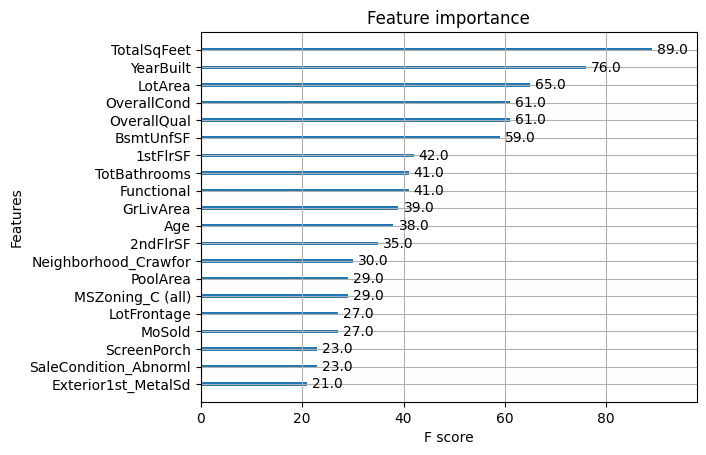

In [135]:
# 使用交叉验证得到的最佳迭代次数来训练模型
xgb_mod = xgb.train(
    params=default_param,
    dtrain=dtrain,
    num_boost_round=best_iteration
)

# 对测试数据进行预测

XGBpred = xgb_mod.predict(dtest)
predictions_XGB = np.exp(XGBpred)  # 逆转对数转换，恢复真实值
print("Predictions:", predictions_XGB[:5])

# 可视化特征重要性
plot_importance(xgb_mod, importance_type='weight', max_num_features=20)
plt.show()


## 3.Averaging predictions

In [146]:
# 解决长度不匹配问题：
# 从原始测试集ID中切片，使其长度与预测结果一致
# 假设丢失的样本在测试集的末尾
test_labels_matched = test_labels[:len(predictions_XGB)]

# 计算加权平均：XGBoost 权重为 1，Lasso 权重为 2，总权重为 3
sub_avg = pd.DataFrame({
    'Id': test_labels_matched,
    'SalePrice': (predictions_XGB + 2 * predictions_lasso) / 3
})

# 检查最终 DataFrame 的行数，现在应该是 1457
print(f"最终预测结果的行数: {len(sub_avg)}")
print("平均预测结果（前6个）：")
print(sub_avg.head())

# # 保存为 CSV 文件
# sub_avg.to_csv('average.csv', index=False)


--- 正在计算平均预测结果并保存 ---
最终预测结果的行数: 1457
平均预测结果（前6个）：
     Id      SalePrice
0  1461  114785.067021
1  1462  161510.155572
2  1463  178260.036676
3  1464  193927.340330
4  1465  192616.634746
